<a href="https://colab.research.google.com/github/cavs1010/wetland_data_ana/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-posthocs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget -q https://raw.githubusercontent.com/cavs1010/utils_wetland/main/utils.py -O utils.py
from utils import calculate_outliers, add_sample_and_outliers_text, plot_boxplot, perform_kruskal_wallis_test, perform_posthoc_dunn_test, create_boxplot_and_stats

# 1. Cleaning Data set

In [68]:
# Import the data set
df = pd.read_csv('/content/drive/MyDrive/🎓Uni/Data_analysis_wetlands/Resources/03_data_jup_Note.csv')

# Deleting empty rows
df = df.dropna(how='all')

# Create a dictionary with current column names as keys and new column names as values
new_column_names = {
    'Article ID(Wetland_id)': 'Wetland_ID',
    'Latitude (decimal)': 'Latitude',
    'Longitude (decimal)': 'Longitude',
    'Standardized Country': 'Country',
    'Standardized Equipment': 'Equipment',
    'Standardized Month': 'Month',
    'Standardized Year': 'Year',
    'Standardized Season': 'Season',
    'Standardized Vegetation in Chamber': 'Vegetation_Chamber',
    'Standardized Type of Vegetation': 'Type_of_Vegetation',
    'Standardized Inlet Source': 'Inlet_Source',
    'Standardized Substrate Type': 'Substrate_Type',
    'Standardized Operational Period (Years)': 'Operational_Period_Years',
    'Standardized GHG Type': 'GHG_Type',
    'Standardize Units': 'Units',
    'Standardized Flux Value': 'Flux_Value'
}

# Rename the columns
df.rename(columns=new_column_names, inplace=True)

# Convert specified columns to numeric types
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['Month'] = pd.to_numeric(df['Month'], errors='coerce')
df['Operational_Period_Years'] = pd.to_numeric(df['Operational_Period_Years'], errors='coerce')
df['Vegetation_Chamber'] = df['Vegetation_Chamber'].str.replace('With plants', 'With Plants')
df['Vegetation_Chamber'] = df['Vegetation_Chamber'].str.replace('No plants', 'No Plants')

# Create a new column 'CO2e' initialized to 0
df['CO2e'] = 0
# Convert CH4 emissions to CO2e and store in the new column
df.loc[df['GHG_Type'] == 'CH4', 'CO2e'] = df['Flux_Value'] * 25
# Convert N2O emissions to CO2e and store in the new column
df.loc[df['GHG_Type'] == 'N2O', 'CO2e'] = df['Flux_Value'] * 298
# CO2 emissions remain the same in terms of CO2e
df.loc[df['GHG_Type'] == 'CO2', 'CO2e'] = df['Flux_Value']
# Fixing inconsitencies between columns 'Type_of_Vegetation' and 'Vegetation_Chamber'
df.loc[:, 'Type_of_Vegetation'] = df.apply(
    lambda row: 'No Plants' if row['Vegetation_Chamber'] == 'No Plants' else row['Type_of_Vegetation'], axis=1
)

df.tail(5)

,Data_ID,Wetland_ID,Latitude,Longitude,Country,Equipment,Month,Year,Season,Vegetation_Chamber,Type_of_Vegetation,Inlet_Source,Substrate_Type,Operational_Period_Years,GHG_Type,Units,Flux_Value,CO2e
371,372,ar_61_typha,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,4.940,1472.120
372,373,ar_61_phragmites,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,CH4,mg CH4 m^-2 d^-1,333.000,8325.000
373,374,ar_61_phragmites,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,7.800,2324.400
374,375,ar_61_no_plants,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,No Plants,No Plants,River Water,Organic,10.0,CH4,mg CH4 m^-2 d^-1,-4.760,-119.000
375,376,ar_61_no_plants,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,No Plants,No Plants,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,-0.257,-76.586


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Data_ID                   376 non-null    int64  
 1   Wetland_ID                376 non-null    object 
 2   Latitude                  364 non-null    float64
 3   Longitude                 364 non-null    float64
 4   Country                   376 non-null    object 
 5   Equipment                 376 non-null    object 
 6   Month                     346 non-null    float64
 7   Year                      376 non-null    int64  
 8   Season                    376 non-null    object 
 9   Vegetation_Chamber        376 non-null    object 
 10  Type_of_Vegetation        376 non-null    object 
 11  Inlet_Source              376 non-null    object 
 12  Substrate_Type            376 non-null    object 
 13  Operational_Period_Years  332 non-null    float64
 14  GHG_Type  

# 2. Data Analysis

## 2.1 Overview of GHG Emissions from Wetlands
In this section, we provide an initial analysis of the greenhouse gas (GHG) emissions data from wetlands. We will examine the general distribution of CO2, CH4, and N2O emissions, comparing their distributions and identifying any key patterns or outliers. This will set the stage for more detailed analyses in subsequent sections.

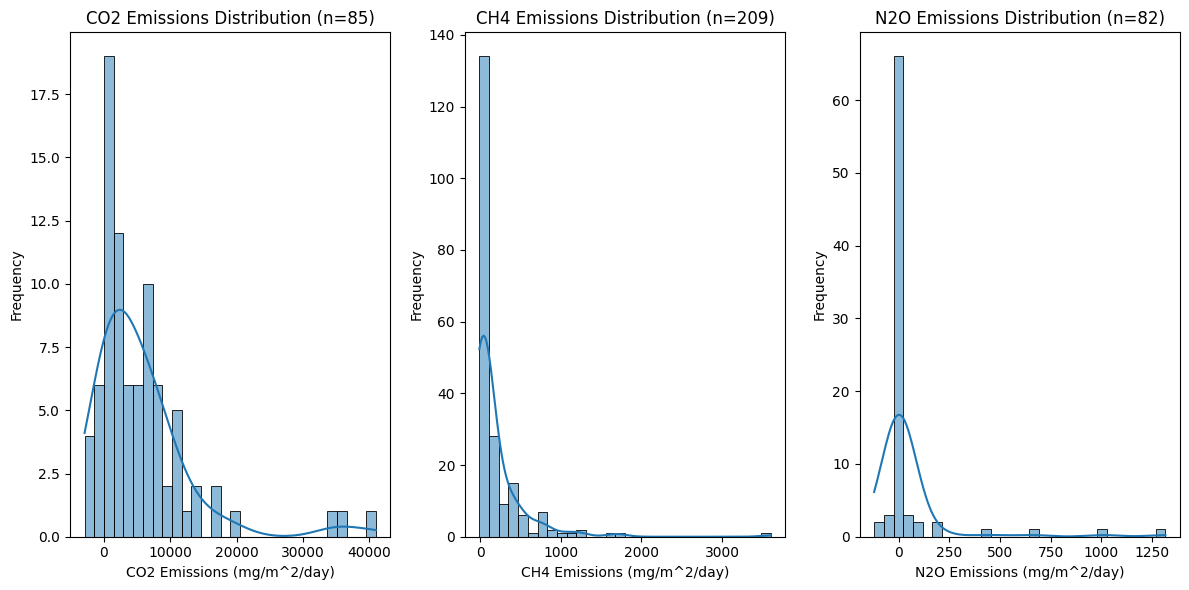

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for each GHG type
co2_data = df[df['GHG_Type'] == 'CO2']['Flux_Value']
ch4_data = df[df['GHG_Type'] == 'CH4']['Flux_Value']
n2o_data = df[df['GHG_Type'] == 'N2O']['Flux_Value']

# Calculate the counts for each GHG type
co2_count = co2_data.shape[0]
ch4_count = ch4_data.shape[0]
n2o_count = n2o_data.shape[0]

# Calculate the number of outliers for each GHG type
co2_outliers = calculate_outliers(df[df['GHG_Type'] == 'CO2']['Flux_Value'])
ch4_outliers = calculate_outliers(df[df['GHG_Type'] == 'CH4']['Flux_Value'])
n2o_outliers = calculate_outliers(df[df['GHG_Type'] == 'N2O']['Flux_Value'])

# Plot histograms
plt.figure(figsize=(12, 6))

# CO2
plt.subplot(1, 3, 1)
sns.histplot(co2_data, bins=30, kde=True)
plt.title(f'CO2 Emissions Distribution (n={co2_count})')
plt.xlabel('CO2 Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

# CH4
plt.subplot(1, 3, 2)
sns.histplot(ch4_data, bins=30, kde=True)
plt.title(f'CH4 Emissions Distribution (n={ch4_count})')
plt.xlabel('CH4 Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

# N2O
plt.subplot(1, 3, 3)
sns.histplot(n2o_data, bins=30, kde=True)
plt.title(f'N2O Emissions Distribution (n={n2o_count})')
plt.xlabel('N2O Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Insights from GHG Emissions Distribution

The histograms with KDE plots for CO2, CH4, and N2O emissions reveal that all three greenhouse gases exhibit a **right-skewed distribution**, indicating that most emissions are concentrated at the lower end of the scale, with a few extreme high values. **CO2 emissions** show a broad distribution with a majority of values below 10,000 mg/m^2/day, while **CH4 emissions** have a very high frequency of low values near zero, suggesting that CH4 emissions are generally low but can occasionally spike. **N2O emissions** are predominantly close to zero, with very few high emission instances. These patterns suggest that while **typical emissions are low**, certain conditions can lead to **significant emission spikes**.


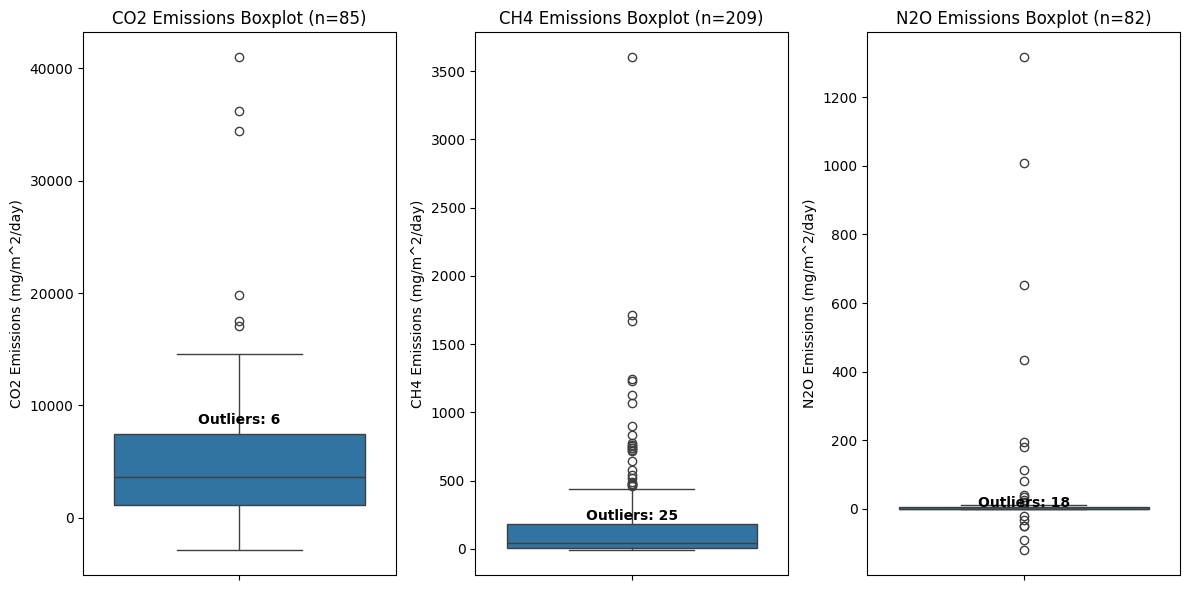

In [9]:
# Create a boxplot for each GHG type to check for outliers
plt.figure(figsize=(12, 6))

# CO2
plt.subplot(1, 3, 1)
sns.boxplot(y=df[df['GHG_Type'] == 'CO2']['Flux_Value'])
plt.title(f'CO2 Emissions Boxplot (n={co2_count})')
plt.ylabel('CO2 Emissions (mg/m^2/day)')
plt.text(0, co2_data.quantile(0.75) + 1.5 * (co2_data.quantile(0.75) - co2_data.quantile(0.25)) * 0.1, f'Outliers: {co2_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

# CH4
plt.subplot(1, 3, 2)
sns.boxplot(y=df[df['GHG_Type'] == 'CH4']['Flux_Value'])
plt.title(f'CH4 Emissions Boxplot (n={ch4_count})')
plt.ylabel('CH4 Emissions (mg/m^2/day)')
plt.text(0, ch4_data.quantile(0.75) + 1.5 * (ch4_data.quantile(0.75) - ch4_data.quantile(0.25)) * 0.1, f'Outliers: {ch4_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

# N2O
plt.subplot(1, 3, 3)
sns.boxplot(y=df[df['GHG_Type'] == 'N2O']['Flux_Value'])
plt.title(f'N2O Emissions Boxplot (n={n2o_count})')
plt.ylabel('N2O Emissions (mg/m^2/day)')
plt.text(0, n2o_data.quantile(0.75) + 1.5 * (n2o_data.quantile(0.75) - n2o_data.quantile(0.25)) * 0.1, f'Outliers: {n2o_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()

### Insights from the Boxplots of GHG Emissions

The boxplots for CO2, CH4, and N2O emissions reveal valuable insights into the **distribution** and presence of **outliers**. CO2 emissions have 6 outliers, indicating occasional **spikes** in emissions, with most values concentrated below 10,000 mg/m^2/day. CH4 emissions display the highest variability with 23 outliers, suggesting frequent **high emission events** and a narrow IQR reflecting low central variability. N2O emissions, while generally low, exhibit 18 outliers, pointing to conditions that lead to **substantial increases**. These outliers across all GHGs suggest that specific environmental factors may cause significant deviations in emissions.


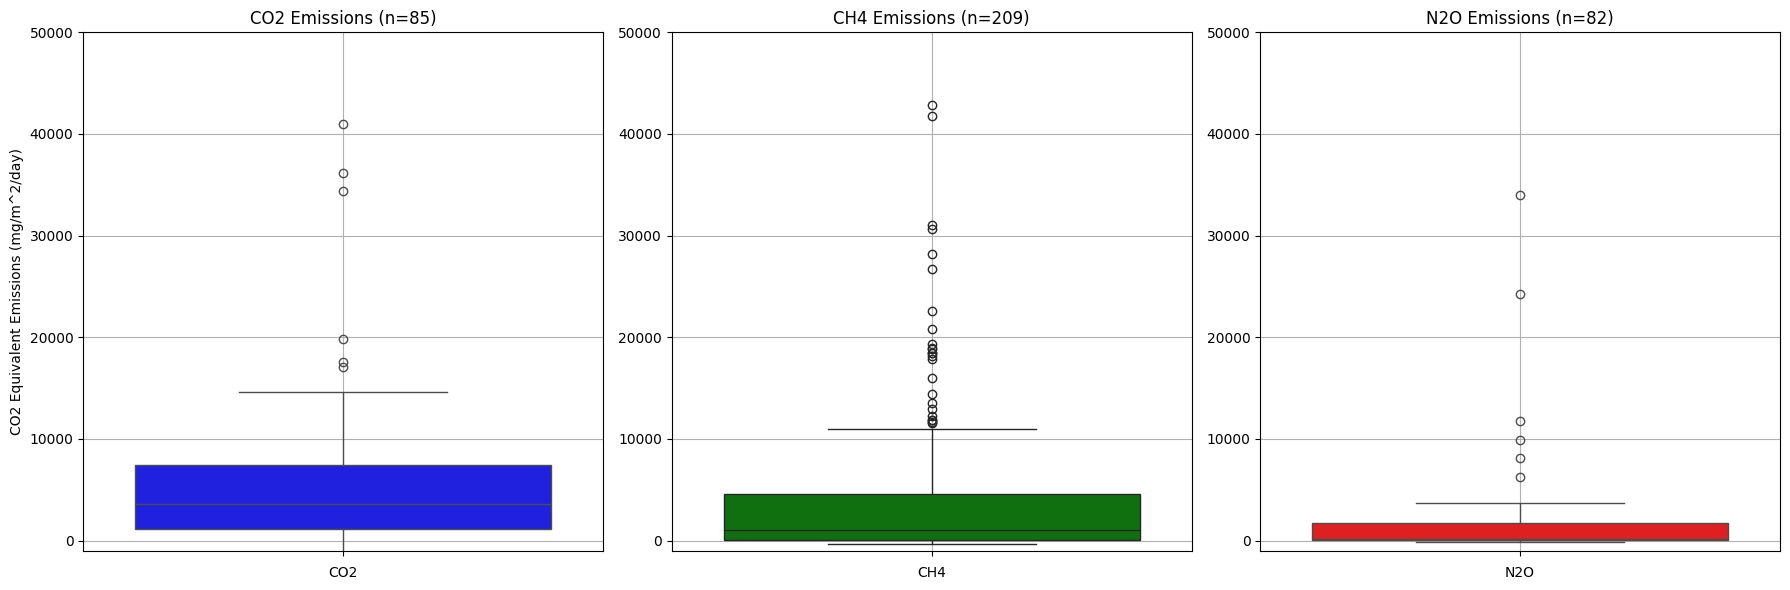

In [10]:
# Set the figure size
plt.figure(figsize=(18, 6))

# Create a common y-axis for all subplots
y_lim = (-1000, 50000)

# CO2 Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=df[df['GHG_Type'] == 'CO2']['CO2e'], color='blue')
plt.title('CO2 Emissions (n={})'.format(df[df['GHG_Type'] == 'CO2'].shape[0]))
plt.ylabel('CO2 Equivalent Emissions (mg/m^2/day)')
plt.xlabel('CO2')
plt.ylim(y_lim)
plt.grid(True)

# CH4 Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=df[df['GHG_Type'] == 'CH4']['CO2e'], color='green')
plt.title('CH4 Emissions (n={})'.format(df[df['GHG_Type'] == 'CH4'].shape[0]))
plt.ylabel('')
plt.xlabel('CH4')
plt.ylim(y_lim)
plt.grid(True)

# N2O Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=df[df['GHG_Type'] == 'N2O']['CO2e'], color='red')
plt.title('N2O Emissions (n={})'.format(df[df['GHG_Type'] == 'N2O'].shape[0]))
plt.ylabel('')
plt.xlabel('N2O')
plt.ylim(y_lim)
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# Extract CO2e emissions for each GHG type
co2e_data = df[df['GHG_Type'] == 'CO2']['CO2e']
ch4e_data = df[df['GHG_Type'] == 'CH4']['CO2e']
n2oe_data = df[df['GHG_Type'] == 'N2O']['CO2e']

# Perform the Kruskal-Wallis H-test
stat, p = kruskal(co2e_data, ch4e_data, n2oe_data)

# Print the results
print('Kruskal-Wallis H-test:')
print('H-statistic:', stat)
print('p-value:', p)

# Interpret the results
alpha = 0.05
if p < alpha:
    print("There is a statistically significant difference between the CO2e emissions of the three GHG types.")
else:
    print("There is no statistically significant difference between the CO2e emissions of the three GHG types.")


Kruskal-Wallis H-test:
H-statistic: 22.68618419861595
p-value: 1.185107355286706e-05
There is a statistically significant difference between the CO2e emissions of the three GHG types.


In [12]:
import scikit_posthocs as sp
import pandas as pd

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'CO2e': df['CO2e'],
    'GHG_Type': df['GHG_Type']
})

# Perform Dunn's test with Bonferroni correction
dunn_result = sp.posthoc_dunn(data, val_col='CO2e', group_col='GHG_Type', p_adjust='bonferroni')

# Print the results
print(dunn_result)


          CH4       CO2       N2O
CH4  1.000000  0.006715  0.025733
CO2  0.006715  1.000000  0.000006
N2O  0.025733  0.000006  1.000000


### Insights from the CO2 Equivalent Emissions Boxplots

The boxplots of CO2 equivalent (CO2e) emissions for CO2, CH4, and N2O provide several key insights. The **median CO2e emissions** for CO2, CH4, and N2O are visibly different, with CH4 and N2O having a lower median CO2e emission compared to CO2. The **interquartile range (IQR)** for CH4 and N2O is much narrower than for CO2, indicating that CO2 emissions have higher variability. All three GHGs show a significant number of outliers, with CO2 outliers reaching up to approximately 40,000 mg/m^2/day. CH4 and N2O also have several high-value outliers, but these are less extreme compared to CO2. The Dunn’s test results show statistically significant differences between the CO2e emissions of the three GHG types: **CH4 vs CO2** (p-value = 0.006715), **CH4 vs N2O** (p-value = 0.025733), and **CO2 vs N2O** (p-value = 0.000006). These p-values indicate that there are **significant differences** between the CO2e emissions for each pair of GHGs, with the most significant difference observed between CO2 and N2O. The CO2 equivalent (CO2e) emissions data demonstrates that **CO2 has the highest median emissions and the greatest variability**. The presence of numerous outliers across all three GHGs indicates that there are conditions under which emissions can spike dramatically. The statistical tests confirm that these differences in emissions are significant, suggesting that each GHG type behaves differently in terms of CO2e emissions. Given these insights, the next step involves exploring whether the **technique used to measure the gas** has any impact on the observed emissions. This analysis will help in understanding if measurement techniques contribute to the variability and differences observed in CO2e emissions across different GHG types.


## 2.2 Impact of Measurement Techniques on GHG Emissions


In [13]:
df['Equipment'].unique()

array(['Static Chambers', 'Eddy Covariance Systems', 'Polyethylene Bags',
       'Vials', 'Portable Gas Flux Systems', 'Floating Chambers',
       'Dynamic Chambers'], dtype=object)

In [14]:
co2_data = df[df['GHG_Type'] == 'CO2']
ch4_data = df[df['GHG_Type'] == 'CH4']
n2o_data = df[df['GHG_Type'] == 'N2O']

### CO2

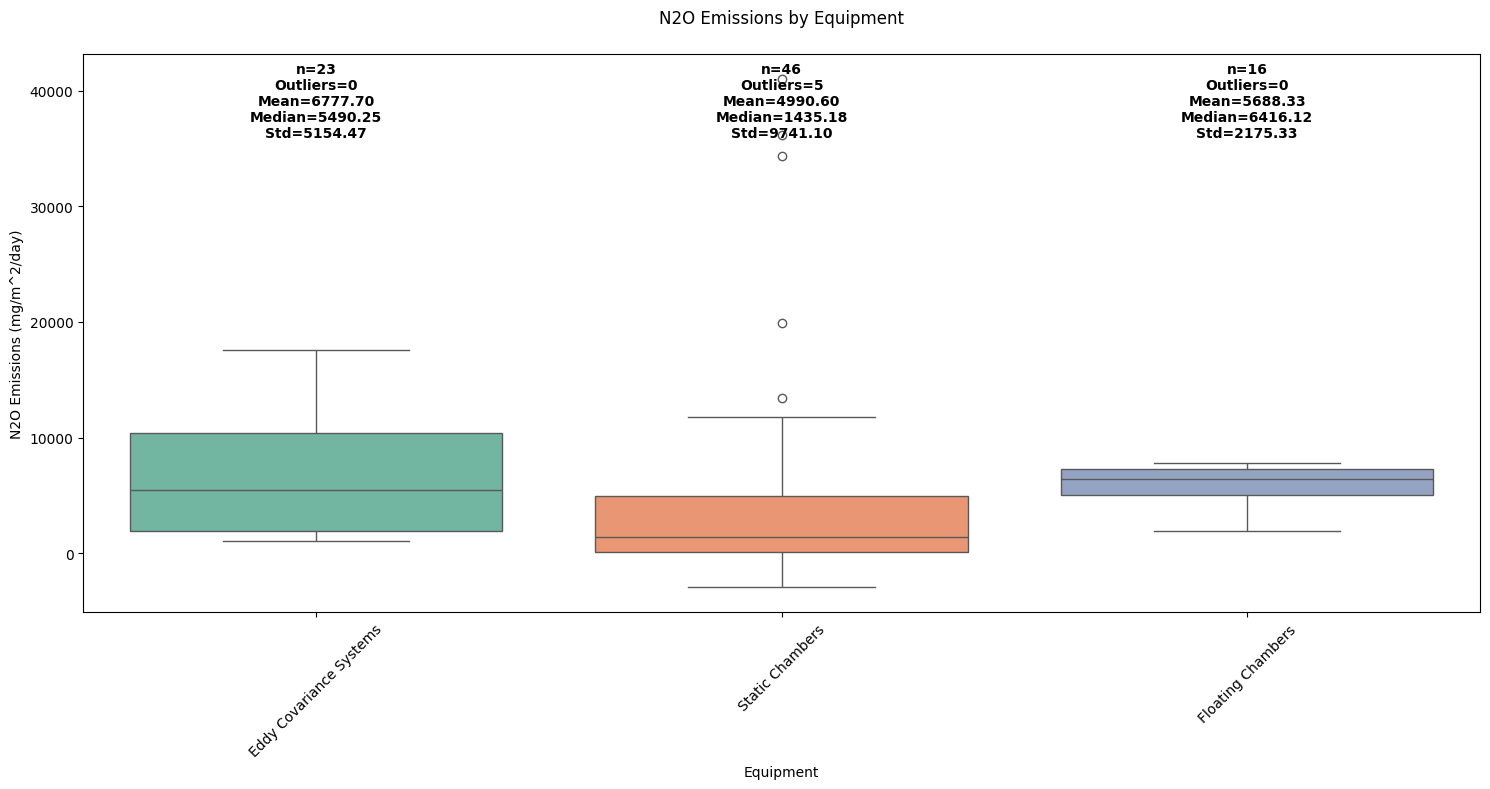

Kruskal-Wallis H Test: Statistic=12.461746701181099, p-value=0.0019677326255352107


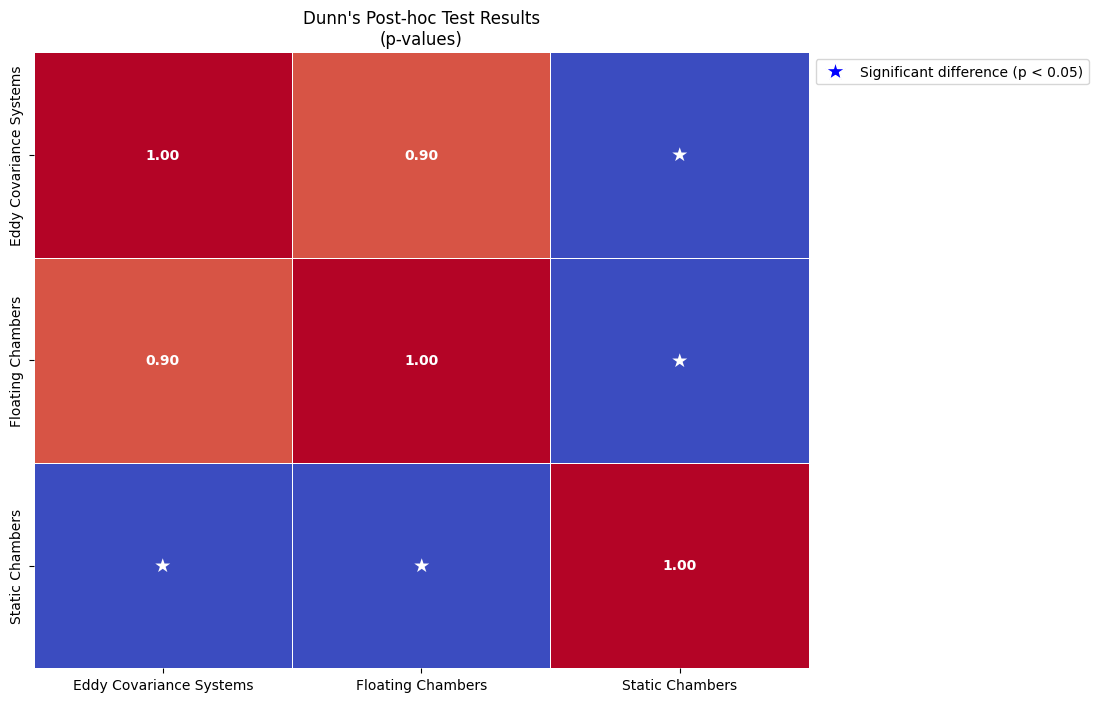

In [15]:
create_boxplot_and_stats(df = co2_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions')


The analysis of CO2 emissions by measurement technique reveals several key insights. **Static Chambers** exhibit the highest variability and the most outliers, indicating a broad range of emission conditions, including extreme values. In contrast, **Eddy Covariance Systems** show moderate variability with a higher median CO2 emission, capturing more typical emission conditions without as many extremes. **Floating Chambers** display the least variability and lower median emissions, suggesting they might provide more consistent measurements but potentially underestimate higher emission events. Statistical analysis using Dunn's test indicates significant differences between Static Chambers and both Eddy Covariance Systems and Floating Chambers, but no significant difference between Eddy Covariance Systems and Floating Chambers. These findings highlight the importance of selecting appropriate measurement techniques for CO2 emission studies, as different methods can yield significantly different results. For the next section, it would be valuable to explore whether similar patterns hold for other greenhouse gases, such as CH4 and N2O, to see if the measurement technique consistently influences emissions across different gases.


### CH4

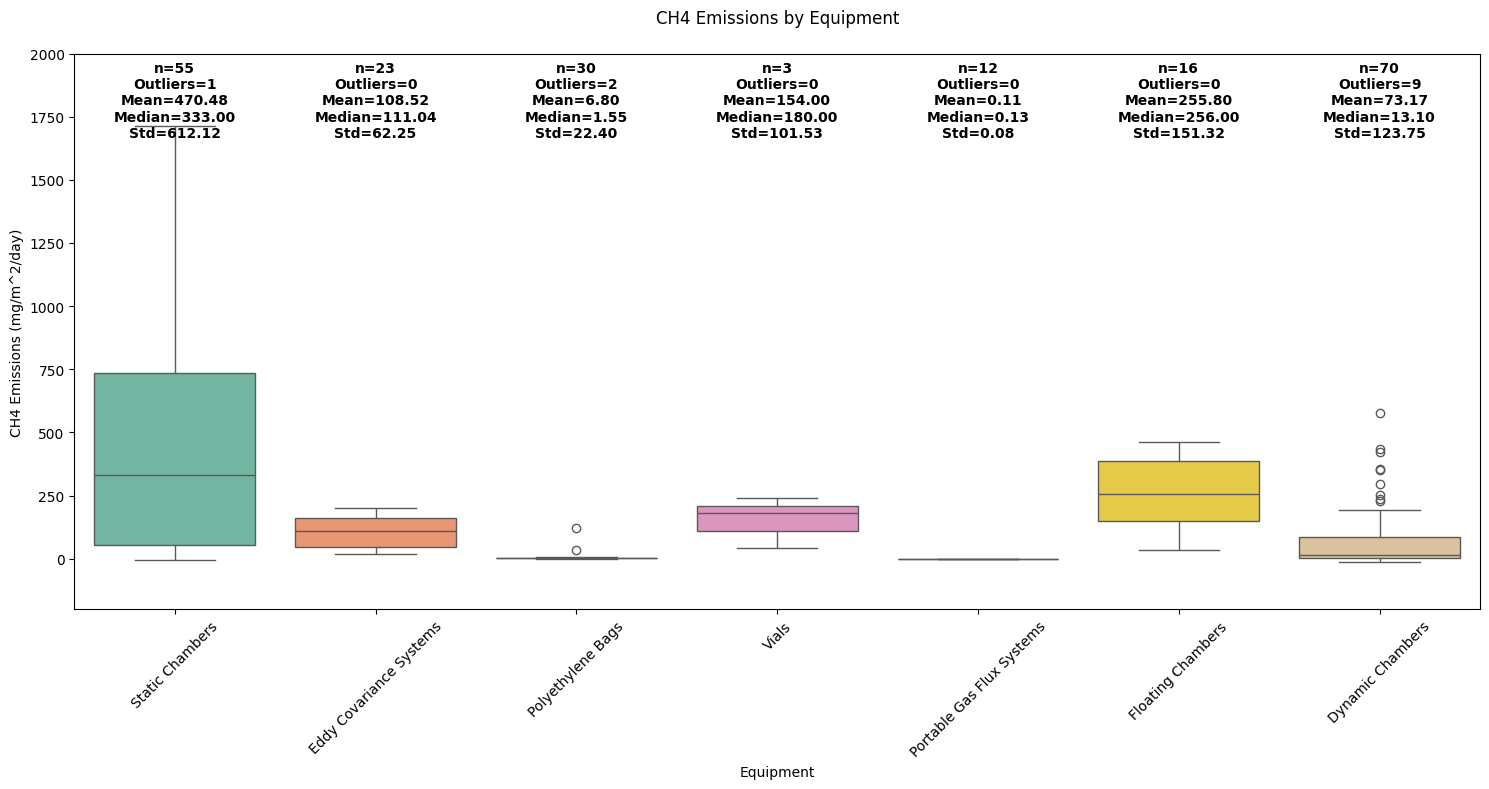

😔 Excluded from analysis due to small sample size: ['Vials']
Kruskal-Wallis H Test: Statistic=99.0994821128702, p-value=8.181377009511486e-20


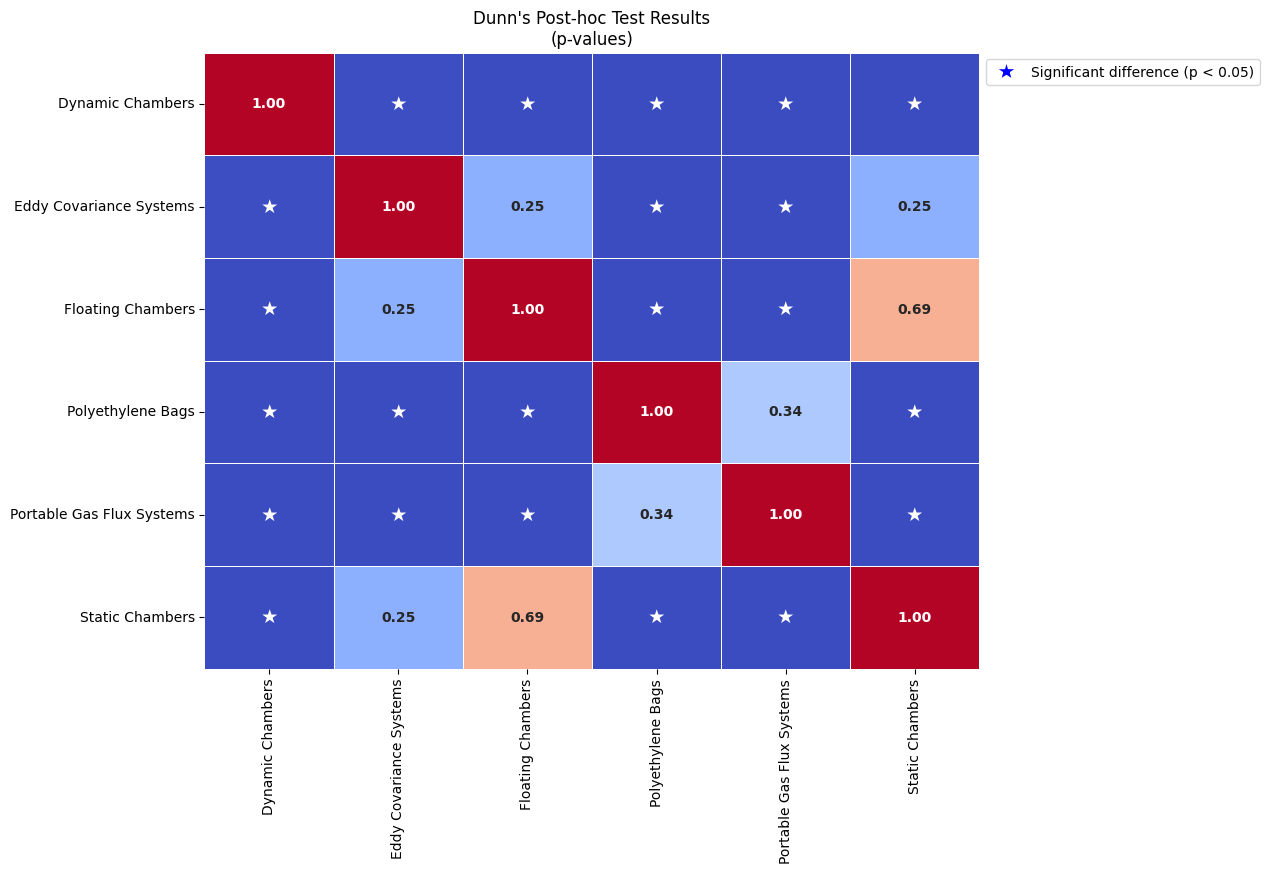

In [16]:
create_boxplot_and_stats(df = ch4_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=10, y_limits=(-200, 2000))

The analysis reveals that there is a **high variation in emissions measured using static chambers**, indicating potential methodological inconsistencies or environmental factors influencing the measurements. Conversely, the **low variation observed in polyethylene bags and portable gas flux systems** might be due to the data originating from a single study or article for each method, leading to more consistent measurements. **Significant differences (p < 0.05) between various measurement techniques**, as indicated by Dunn's post-hoc test, suggest that the choice of method can impact recorded CH4 emissions. However, it is essential to consider other influencing factors such as environmental conditions, site-specific characteristics, and study design. The results underscore the need for **cautious interpretation of the method influence on emissions**, emphasizing the importance of accounting for a broad range of variables. Moving forward, it would be beneficial to investigate other influencing factors by filtering the data by equipment type and examining variables like vegetation type, substrate type, season, and operational period. This approach will help isolate the effect of each factor, providing a more nuanced understanding of their influence on GHG emissions.


### N2O

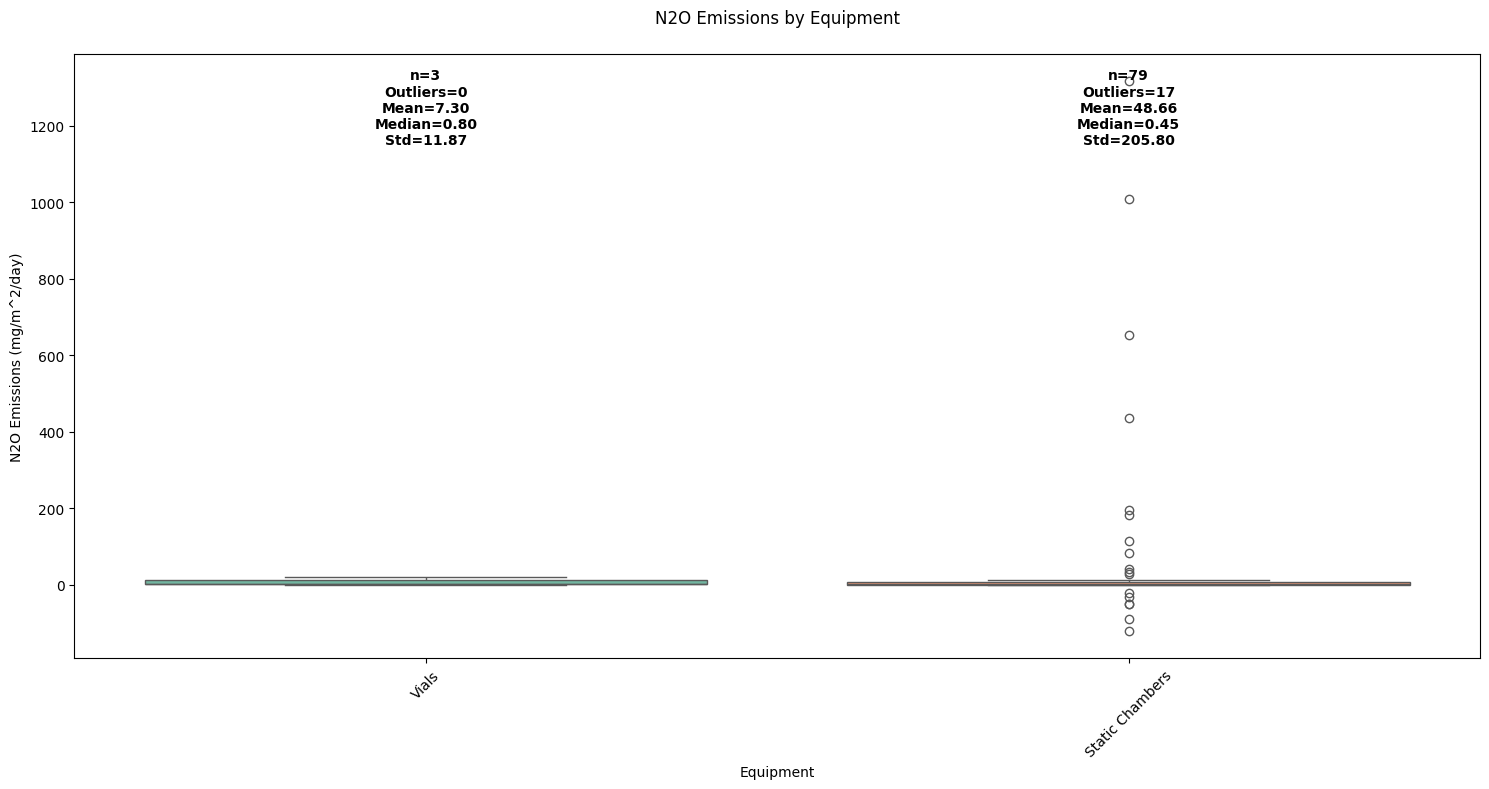

Kruskal-Wallis H Test: Statistic=0.11119704622060224, p-value=0.738785409850581
No significant difference found by Kruskal-Wallis test.


In [17]:
create_boxplot_and_stats(df = n2o_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=1, y_limits=None)

The plot of **N2O emissions by equipment type** shows significant variability in measurements taken with **static chambers**, with many outliers present. This high variability reinforces the idea that other factors besides the measurement method might influence the emissions. The vials method, with a small sample size, shows no variability, which limits the reliability of this comparison. To gain further insights, it is crucial to filter the data and focus on **chamber-based methods** (**static, floating, and dynamic chambers**) and investigate the impact of other factors such as **soil type, water content, vegetation type, season, and operational conditions** on N2O emissions. This approach will help identify the specific factors contributing to the variability within a more controlled subset of data. **Note**: The sample size for the vials method is very small (**n=3**), limiting the reliability of the comparison.


## 2.3 Impact of Seasons on GHG Emissions
**Note**: From this point forward, the analysis will be **filtered by the type of greenhouse gas (GHG)** and the use of **chamber-based measurement techniques** (static, floating, and dynamic chambers) to measure the GHG emissions. This focused approach will help control for variability and isolate the impact of other environmental and operational factors on emissions.


In [18]:
# Filter the dataset for CO2 emissions and chamber-based measurements
co2_chamber_data = co2_data[co2_data['Equipment'].isin(['Static Chambers', 'Floating Chambers', 'Dynamic Chambers'])]

# Filter the dataset for CH4 emissions and chamber-based measurements
ch4_chamber_data = ch4_data[ch4_data['Equipment'].isin(['Static Chambers', 'Floating Chambers', 'Dynamic Chambers'])]

# Filter the dataset for N2O emissions and chamber-based measurements
n2o_chamber_data = n2o_data[n2o_data['Equipment'].isin(['Static Chambers', 'Floating Chambers', 'Dynamic Chambers'])]


### CO2

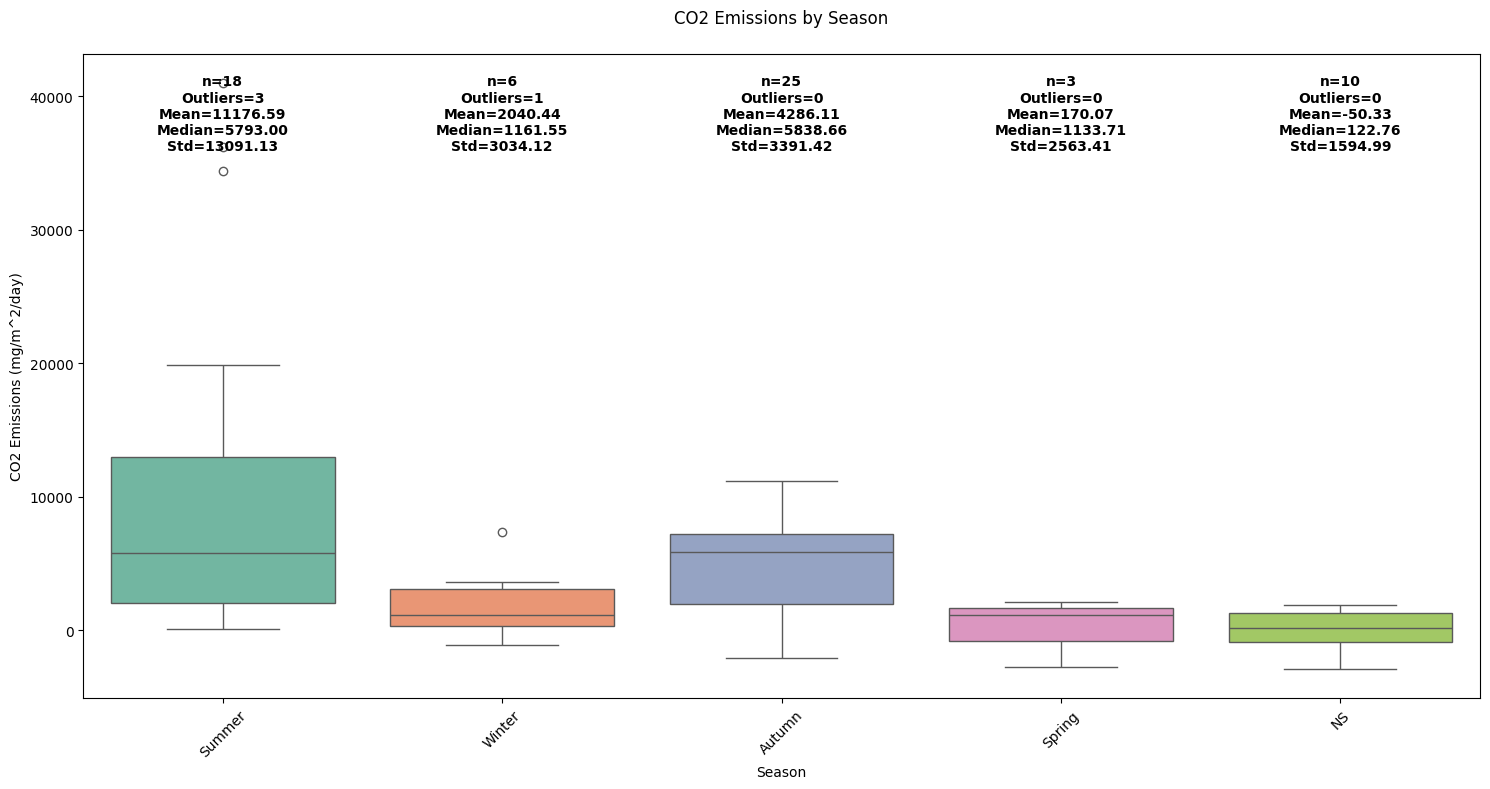

😔 Excluded from analysis due to small sample size: ['Winter', 'Spring']
Kruskal-Wallis H Test: Statistic=15.263796878639653, p-value=0.00048473973529556796


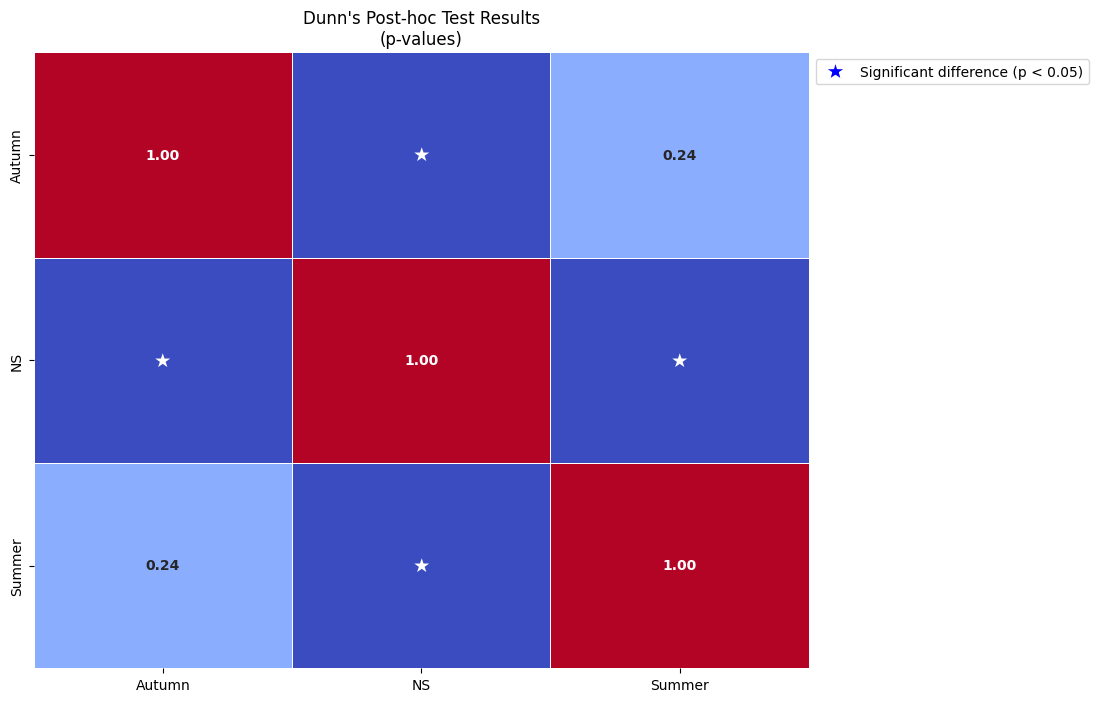

In [19]:
create_boxplot_and_stats(df = co2_chamber_data, value_column = 'Flux_Value', category_column = 'Season', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=10, y_limits=None)


The Kruskal-Wallis test found no statistically significant difference in **CO2 emissions** between different seasons, including **summer and winter**. Despite the visual differences in the boxplots, the high variability within each season and the presence of outliers, especially in summer, suggest that seasonal changes may not strongly influence **CO2 emissions** in constructed wetlands. Additionally, the relatively small sample sizes for each season might affect the power of the statistical test to detect significant differences.

There is no reliable way to do a comparison when including **winter and spring** because the sample size is not big enough. Among **summer and autum**, there was not a huge difference, and the statistical analysis shows that there is no significant difference. Therefore, I might investigate the temperatures using an API to retrieve the temperatures around this time and at the specific latitude and longitude.


### CH4

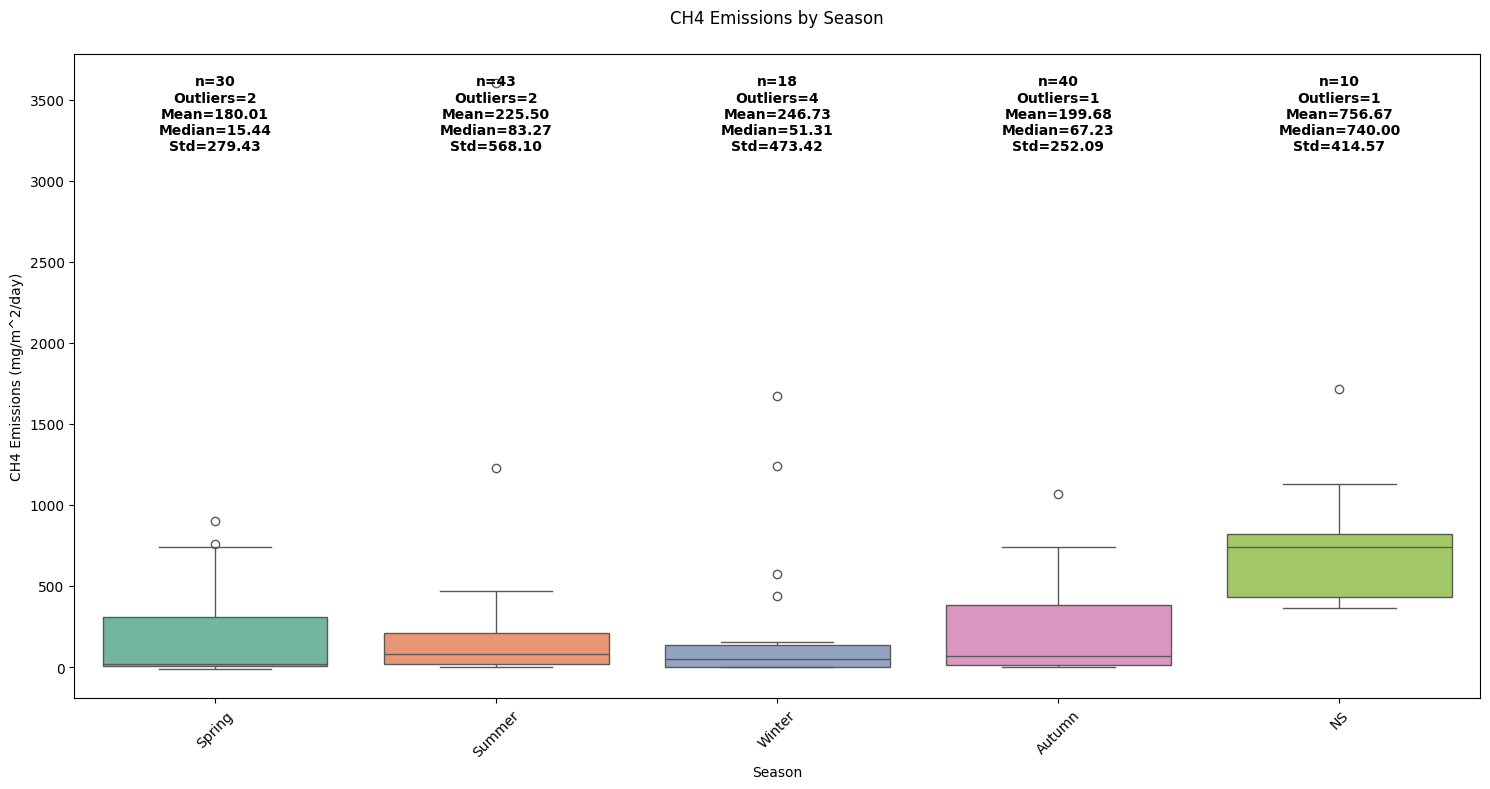

Kruskal-Wallis H Test: Statistic=20.426079257553194, p-value=0.00041139272059760926


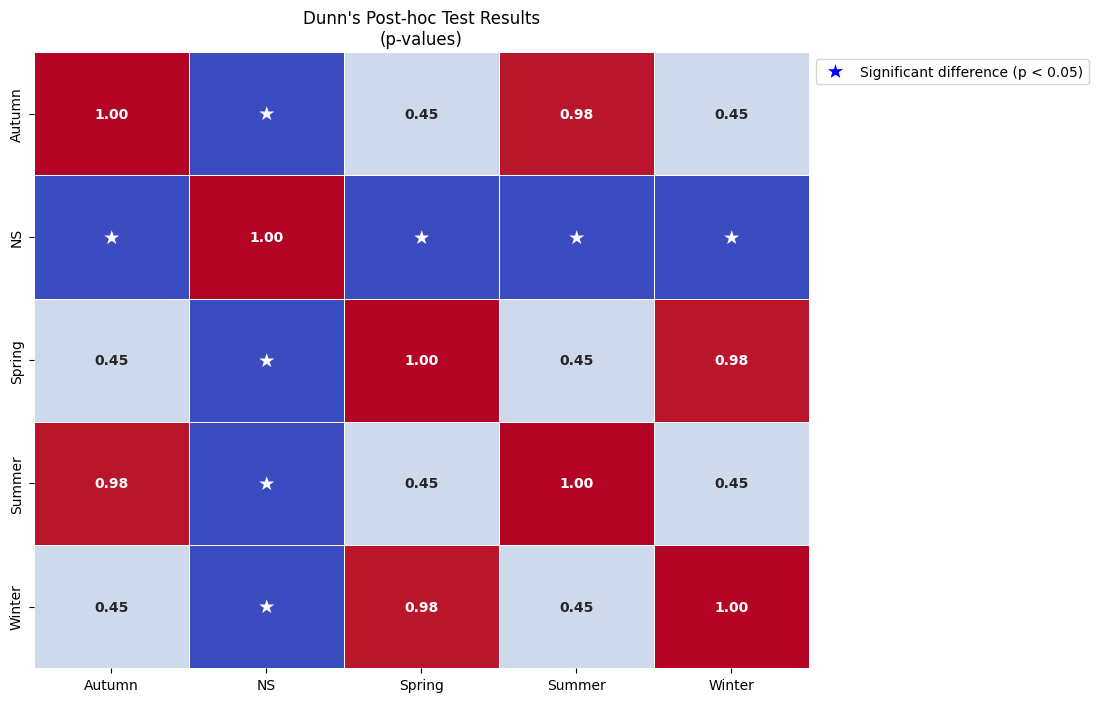

In [20]:
create_boxplot_and_stats(df = ch4_chamber_data, value_column = 'Flux_Value', category_column = 'Season', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=1, y_limits=None)


The boxplot reveals that **CH4 emissions** across different seasons do not show significant variations. This observation is supported by the statistical analysis, indicating no substantial differences between the seasons. The median CH4 emissions are relatively consistent across all seasons, with some slight variations but no pronounced differences. This suggests that **CH4 emissions** might not be strongly influenced by seasonal changes. Although outliers are present in all seasons, their impact does not seem significant enough to create statistical differences, implying that occasional spikes in CH4 emissions do not follow a seasonal pattern.

The absence of significant seasonal differences in CH4 emissions is intriguing and warrants further investigation. It may be necessary to explore other environmental factors or mechanisms that could be influencing **CH4 emissions**, such as **temperature, moisture levels, or microbial activity**. Additionally, the **operational period** of the wetland and the type of **vegetation** present might play a more significant role in influencing **CH4 emissions** than the season itself. By focusing on these factors, we could gain a better understanding of the underlying mechanisms driving **CH4 emissions** in constructed wetlands.


### N2O

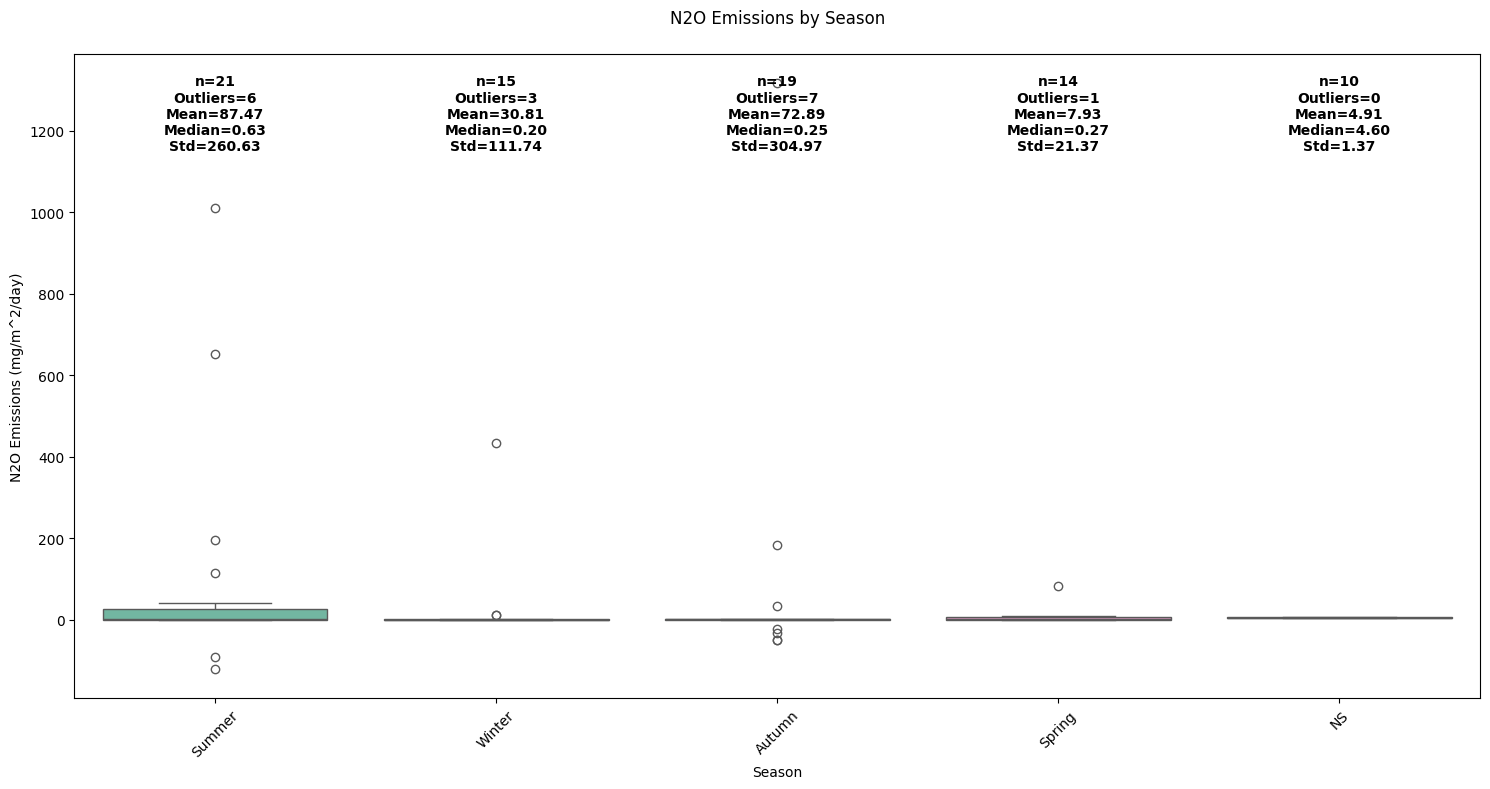

Kruskal-Wallis H Test: Statistic=9.357868650566052, p-value=0.05275109603428018
No significant difference found by Kruskal-Wallis test.


In [21]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Season', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=1, y_limits=None)

The above analysis indicates no significant difference in **N2O emissions** across different seasons. This lack of variation suggests that other factors might be influencing **N2O emissions** in constructed wetlands. It's noteworthy that the number of outliers varies among the seasons, with **Summer** showing the highest number of outliers. This could indicate occasional spikes in emissions during the summer months, but the overall trend remains consistent across seasons. Given the absence of significant seasonal variation, the next step is to investigate the impact of vegetation presence on **N2O emissions**. Vegetation can play a crucial role in greenhouse gas emissions by influencing soil properties and microbial activities. Therefore, comparing emissions with and without vegetation will provide valuable insights. Additionally, leveraging an API to retrieve climate variables such as **temperature** and **moisture levels** for the specific latitudes and longitudes of each wetland measurement is essential. These climate variables may have a substantial impact on emissions and could help explain the observed patterns. By incorporating these additional factors, we aim to gain a deeper understanding of the mechanisms driving **greenhouse gas emissions** in constructed wetlands and identify potential mitigation strategies.



## 2.4 Impact of Vegetation on GHG Emissions  
**Note:** The classification of "plant" or "no plant" is based on the presence of plants inside the chamber during the measurements. Some studies included plants within the chamber, while others did not. This classification does not refer to the presence or absence of plants in the wetland as a whole, but specifically to the conditions within the measurement chamber.


### CO2

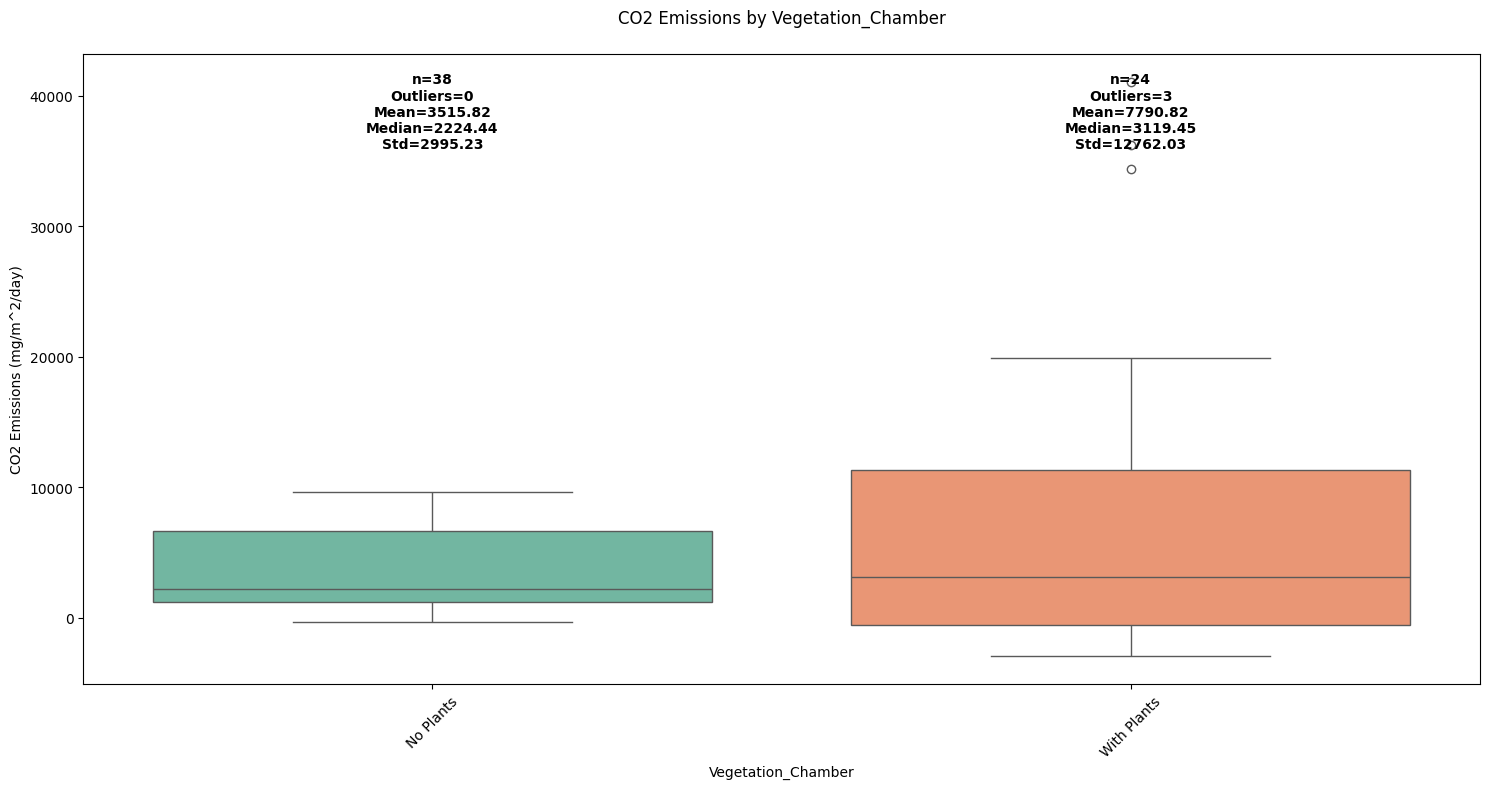

Kruskal-Wallis H Test: Statistic=0.030075187969941908, p-value=0.8623197383893976
No significant difference found by Kruskal-Wallis test.


In [22]:
create_boxplot_and_stats(df = co2_chamber_data, value_column = 'Flux_Value', category_column = 'Vegetation_Chamber', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=10, y_limits=None)

### CH4

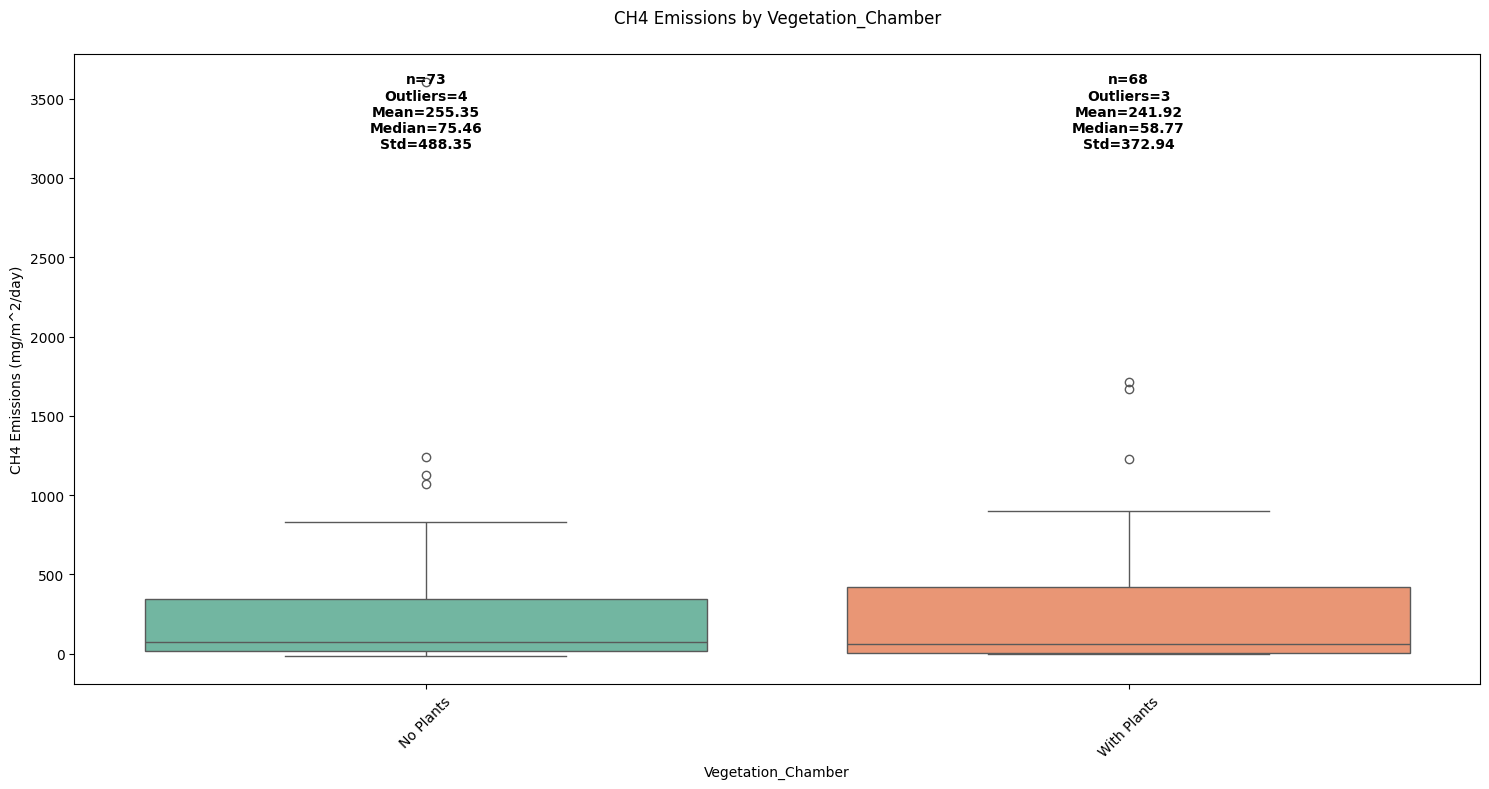

Kruskal-Wallis H Test: Statistic=0.7760096347239149, p-value=0.3783643204029047
No significant difference found by Kruskal-Wallis test.


In [23]:
create_boxplot_and_stats(df = ch4_chamber_data, value_column = 'Flux_Value', category_column = 'Vegetation_Chamber', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=10, y_limits=None)

### N2O

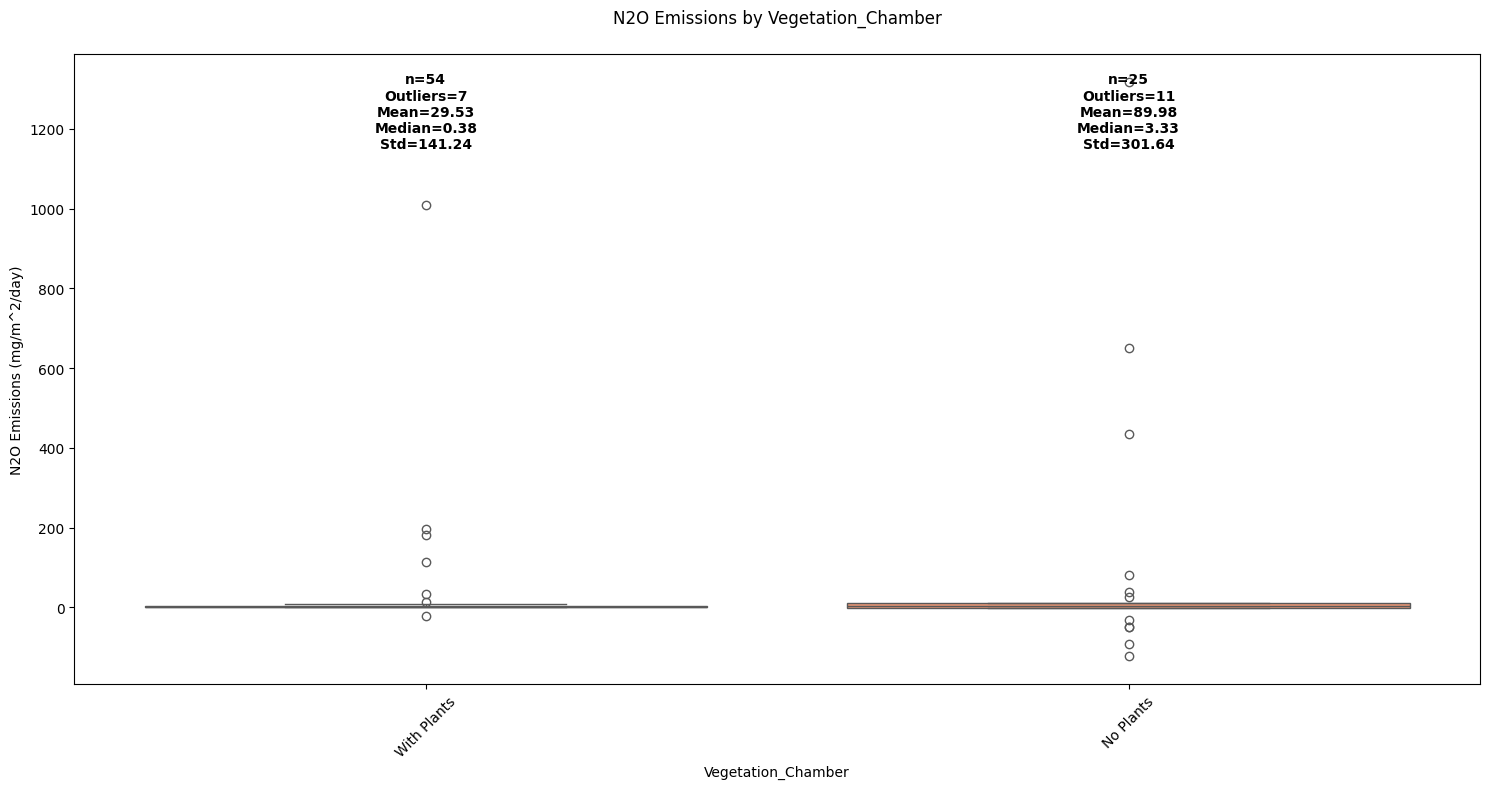

Kruskal-Wallis H Test: Statistic=0.016002921662904273, p-value=0.8993340477302887
No significant difference found by Kruskal-Wallis test.


In [24]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Vegetation_Chamber', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=10, y_limits=None)


The statistical analysis revealing no significant difference between chambers with and without plants for CO2, CH4, and N2O emissions suggests that the **presence of vegetation** inside the chamber may not be as influential on greenhouse gas (GHG) emissions as initially hypothesized. Here are some insights based on this finding:

The initial visual inspection of the boxplots suggested a higher median CO2 emission for chambers with plants. However, the lack of statistical significance implies that the observed differences could be due to natural variability in the data rather than the presence of vegetation. This could indicate that other factors, such as soil properties or water conditions, might be more critical in influencing CO2 emissions in constructed wetlands.

The similar distributions of CH4 emissions in both categories suggest that methane production and oxidation processes might be occurring at comparable rates regardless of the presence of plants. This could mean that the methanogenic and methanotrophic microbial communities in the soil are not significantly impacted by the vegetation within the chamber.

The high variability in N2O emissions and the lack of significant difference between the two conditions indicate that N2O emissions are likely influenced by complex and interacting factors beyond just the presence of vegetation. These could include nitrogen availability, soil moisture, and microbial activity, which may not be directly affected by whether plants are present in the chamber.

**Implications**

The findings suggest that:

- **Focus on Other Factors**: Research should perhaps shift focus to other environmental and operational factors that might influence GHG emissions more strongly than vegetation within chambers. These could include soil characteristics, water chemistry, temperature, and hydrological conditions.
  
- **Plant Influence on Larger Scale**: The influence of plants might be more apparent at larger spatial scales or over longer temporal scales than those captured within individual chamber measurements. Thus, field-scale studies or long-term monitoring might be necessary to detect vegetation effects.

- **Methodological Considerations**: The lack of observed differences highlights the importance of considering methodological aspects in GHG measurement studies. Ensuring consistency in chamber deployment and accounting for potential confounding variables is crucial for accurate emission assessments.


## 2.5 Impact of Vegetation Type

### CO2

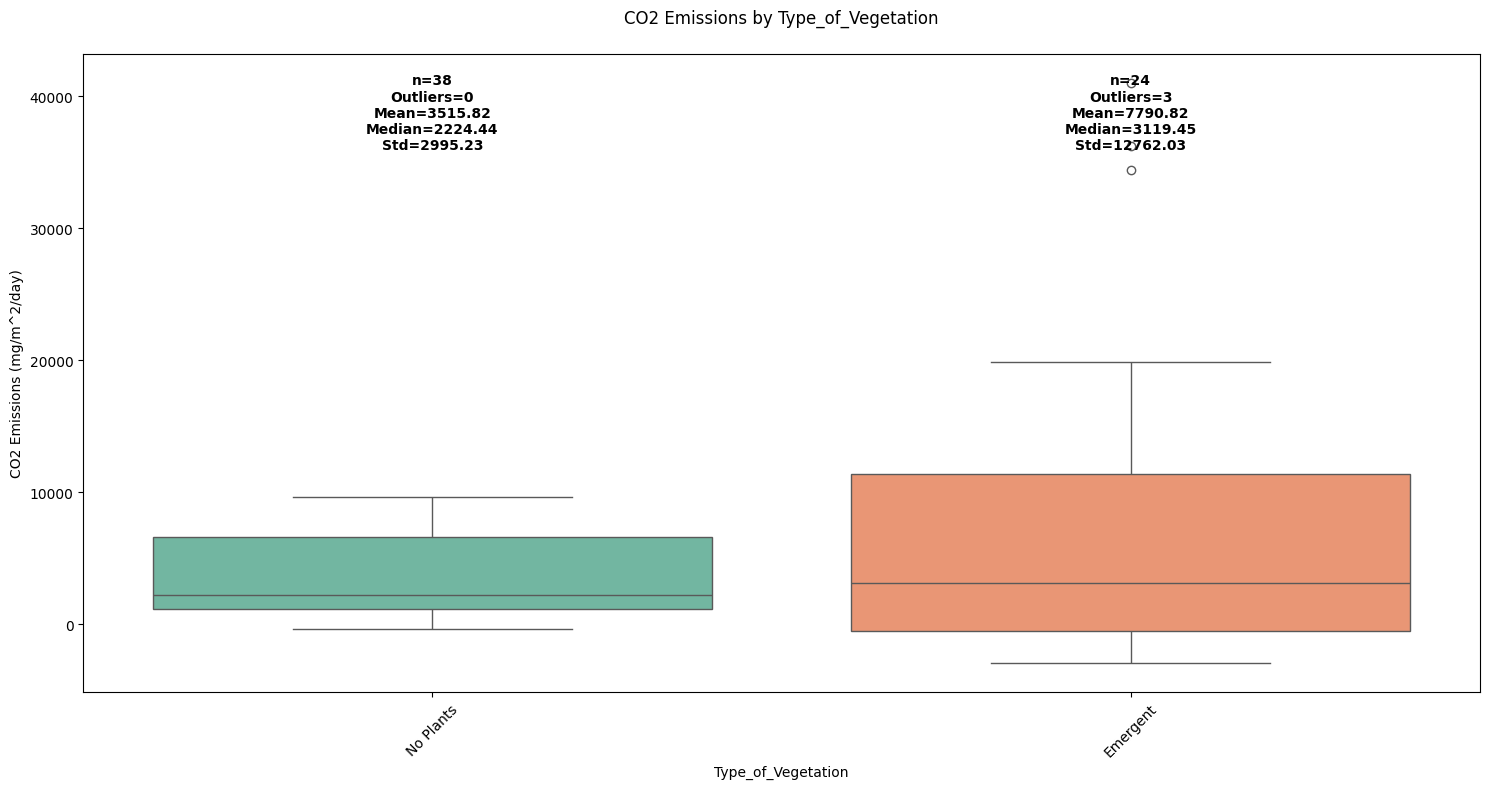

Kruskal-Wallis H Test: Statistic=0.030075187969941908, p-value=0.8623197383893976
No significant difference found by Kruskal-Wallis test.


In [25]:
create_boxplot_and_stats(df = co2_chamber_data, value_column = 'Flux_Value', category_column = 'Type_of_Vegetation', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=2, y_limits=None)

### CH4

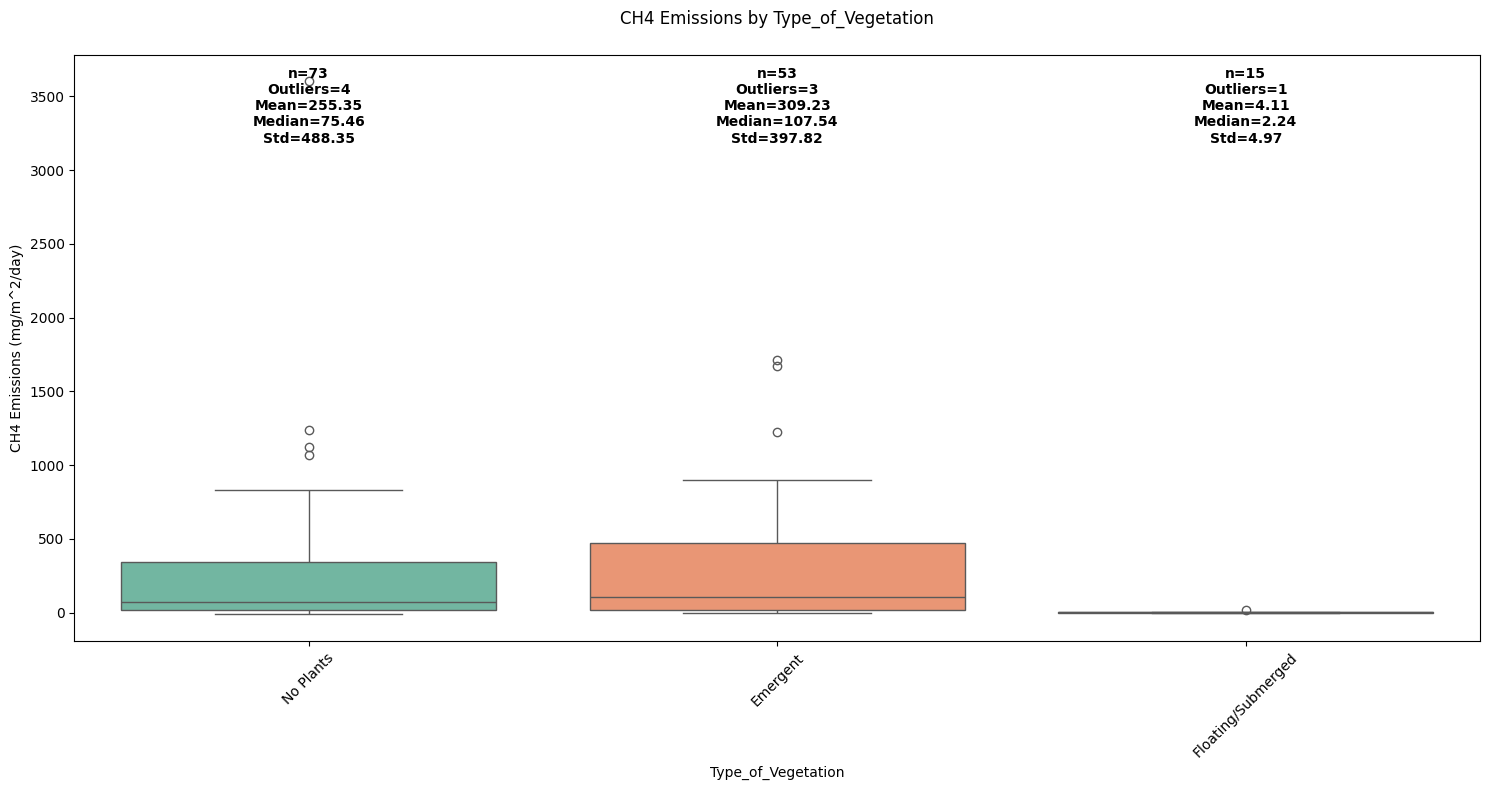

Kruskal-Wallis H Test: Statistic=24.47454560544633, p-value=4.846407724926764e-06


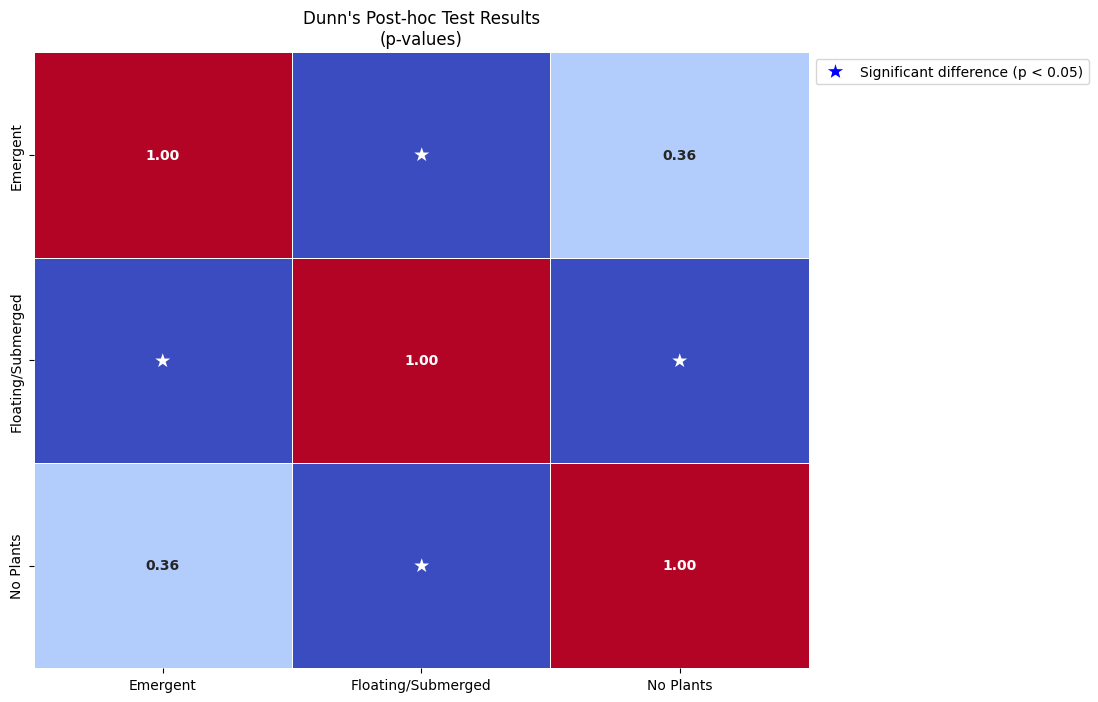

In [26]:
create_boxplot_and_stats(df = ch4_chamber_data, value_column = 'Flux_Value', category_column = 'Type_of_Vegetation', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=2, y_limits=None)

### N2O

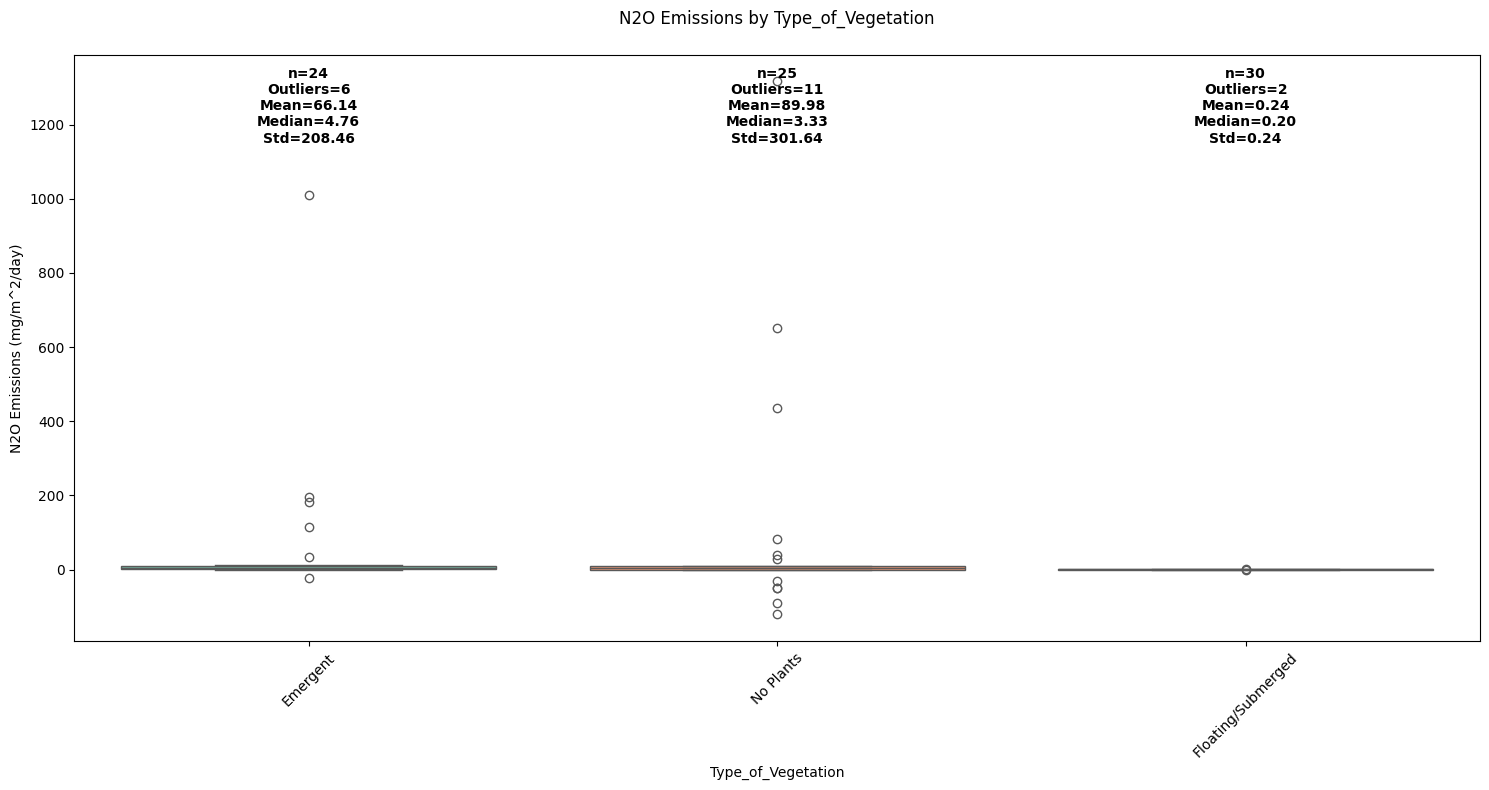

Kruskal-Wallis H Test: Statistic=17.10015046564004, p-value=0.0001935305391621698


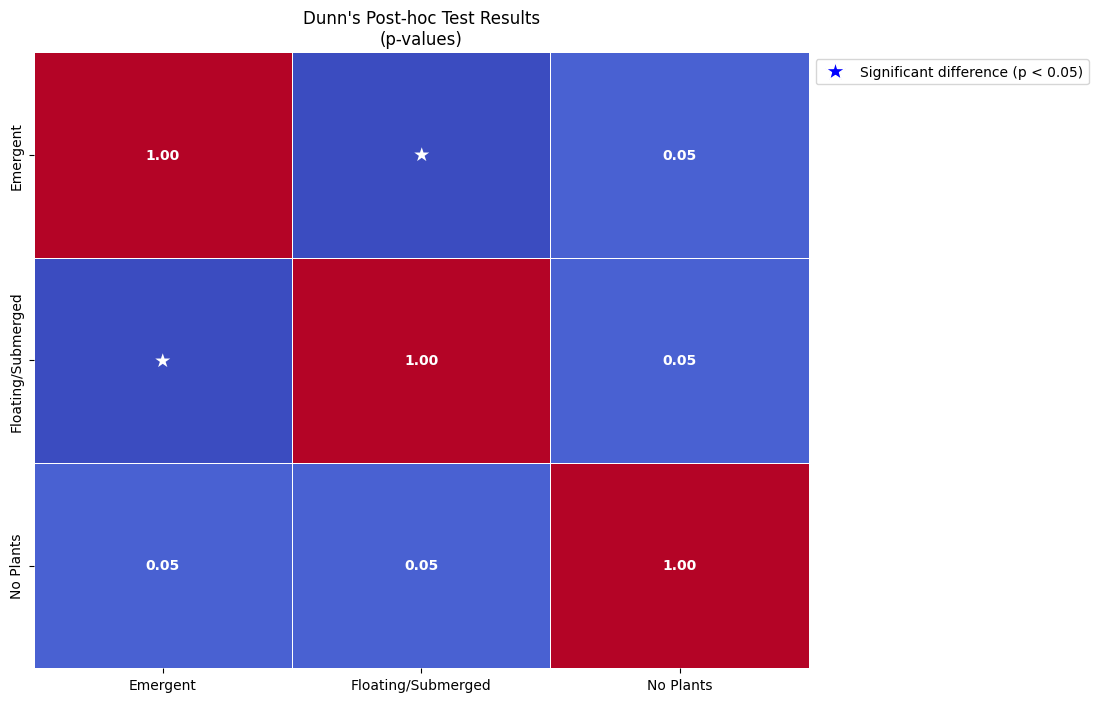

In [27]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Type_of_Vegetation', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=2, y_limits=None)

From the analysis of the boxplots and statistical tests, several insights emerge regarding the greenhouse gas (GHG) emissions based on the type of vegetation present in the chamber. For **CO2** emissions, the data shows that there is no significant difference between chambers with emergent plants and those without plants. This result is consistent with previous findings and is not particularly valuable, as the studies analyzed only included emergent plants, leading to similar results when comparing the presence or absence of plants.

For **CH4** emissions, statistical analysis reveals a significant difference between chambers with emergent plants and those with floating/submerged plants. Chambers with emergent plants tend to emit more CH4 compared to those with floating/submerged vegetation. This indicates that the type of vegetation plays a crucial role in methane emissions, with emergent plants potentially providing more favorable conditions for methanogenic bacteria or influencing oxygen levels in the substrate, which in turn affects methane production. On the other hand, floating/submerged plants could create more aerobic conditions in the water column, which inhibits methane production, or they might facilitate methane oxidation by methanotrophic bacteria.

For **N2O** emissions, a statistically significant difference is observed, with chambers containing emergent plants exhibiting higher N2O emissions compared to those with floating/submerged vegetation. This could be due to the influence of plant type on the nitrogen cycle, including nitrification and denitrification processes in the wetland soil, which are critical pathways for N2O production. Floating/submerged plants could promote more complete denitrification, leading to the reduction of N2O to N2, thus emitting less N2O compared to emergent plants.

Interestingly, floating/submerged plants also emit less GHGs compared to chambers without plants. This could be due to the unique microenvironments created by these plants. Floating/submerged plants may enhance the diffusion of oxygen into the water column and sediment, promoting aerobic conditions that inhibit methanogenesis and favor methane oxidation. Additionally, these plants might support microbial communities that facilitate complete denitrification, thus reducing N2O emissions.


## 2.6 Impact of Inlet Source

### CO2

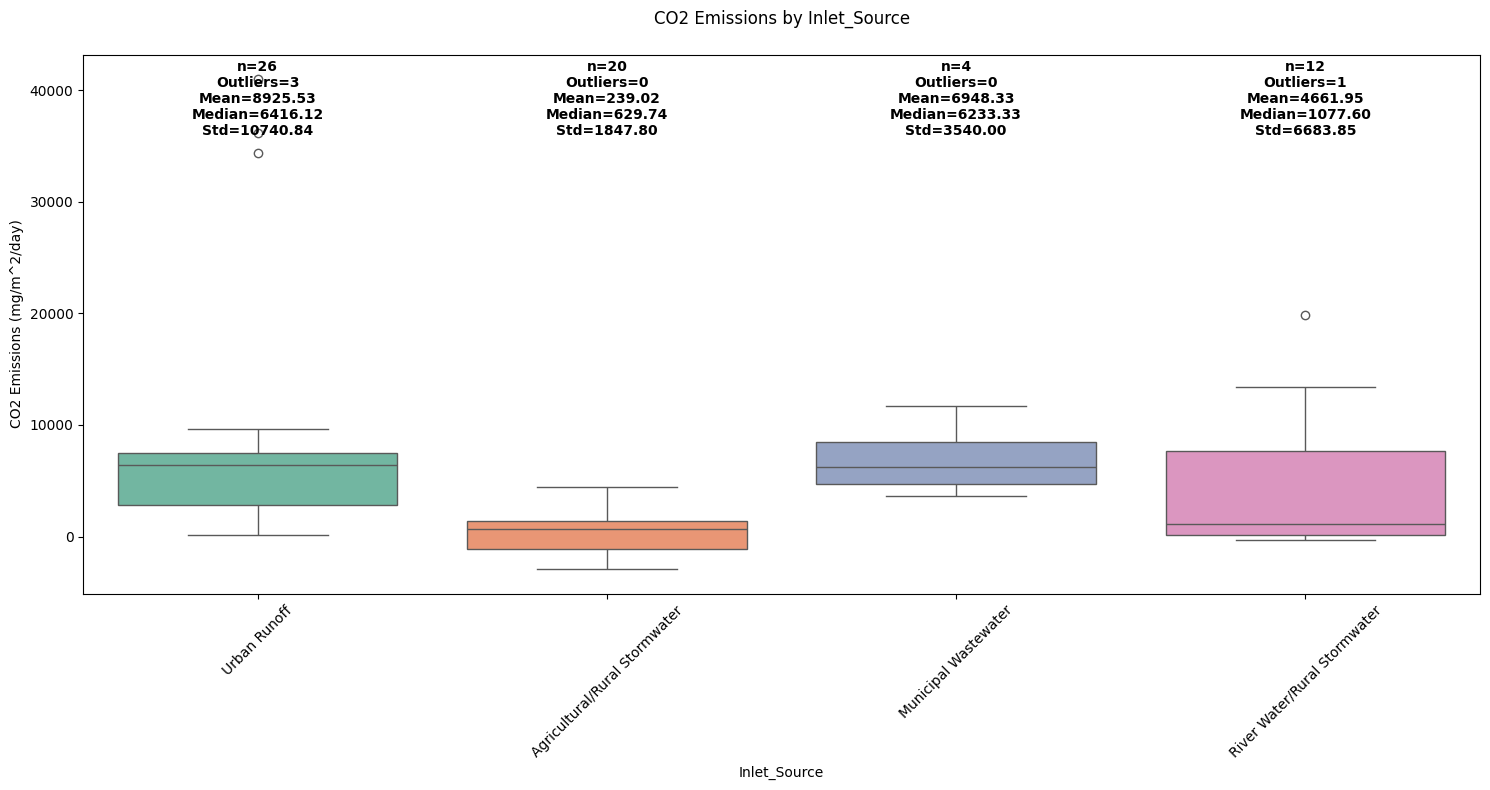

😔 Excluded from analysis due to small sample size: ['Municipal Wastewater']
Kruskal-Wallis H Test: Statistic=25.644904014746203, p-value=2.699478349867277e-06


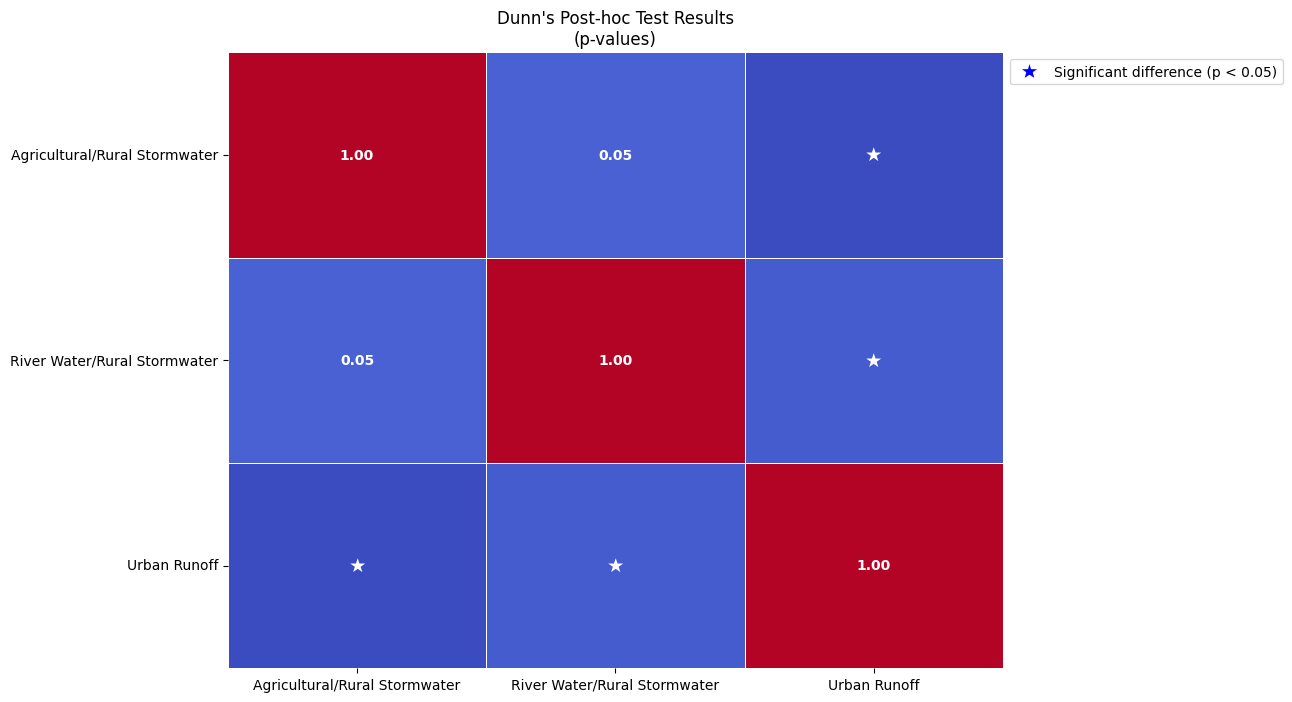

In [28]:
create_boxplot_and_stats(df = co2_chamber_data, value_column = 'Flux_Value', category_column = 'Inlet_Source', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=10, y_limits=None)

### CH4

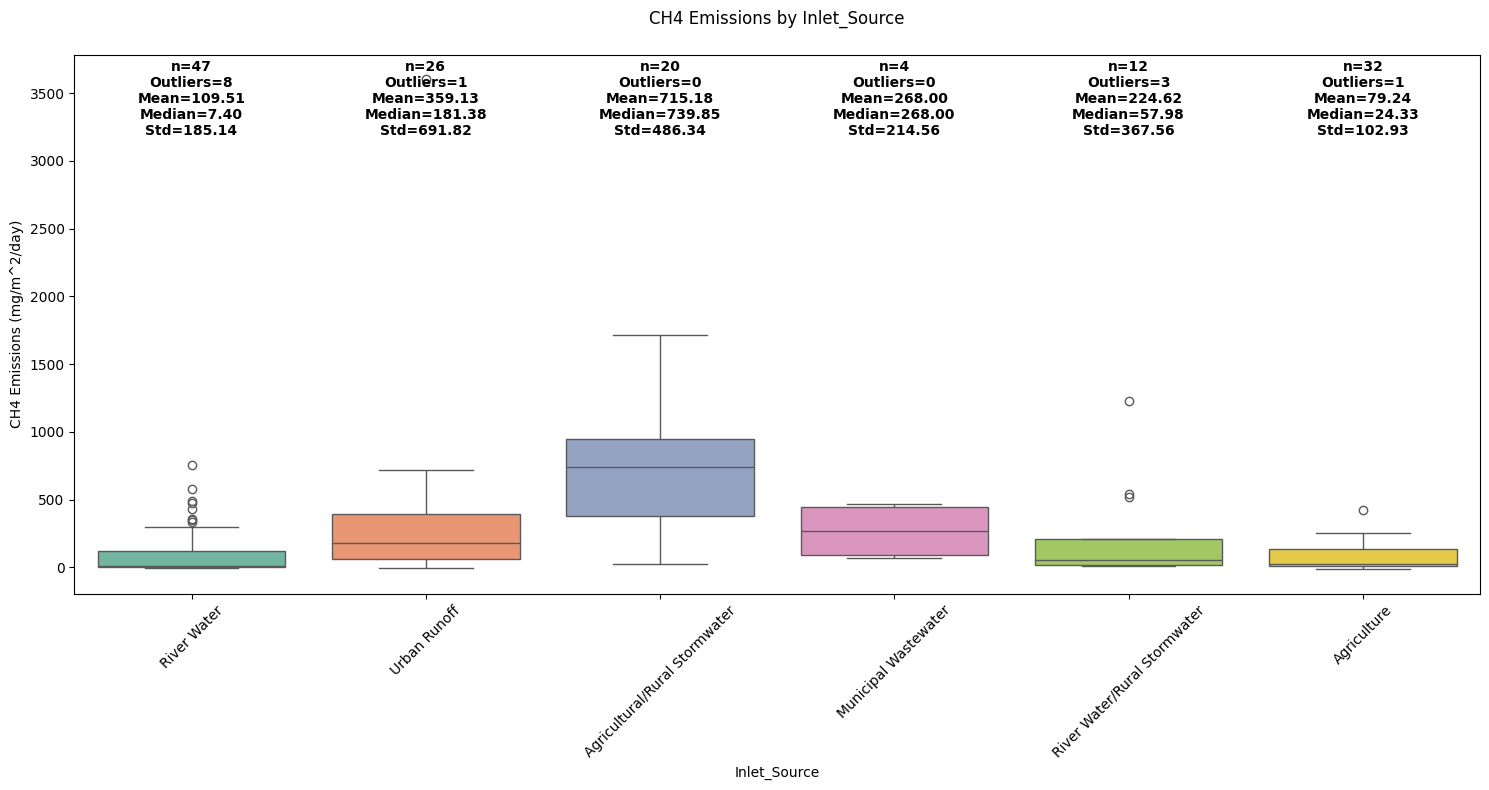

😔 Excluded from analysis due to small sample size: ['Municipal Wastewater']
Kruskal-Wallis H Test: Statistic=42.8182746330116, p-value=1.1286387031734872e-08


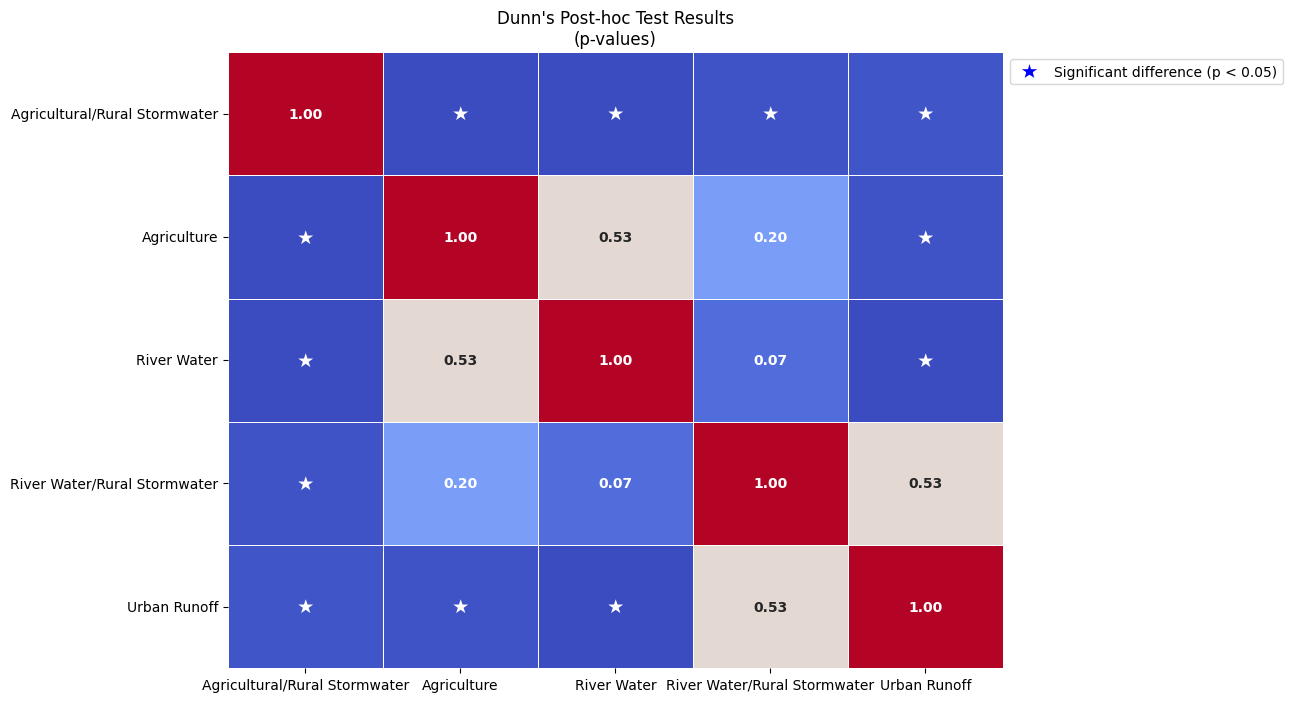

In [29]:
create_boxplot_and_stats(df = ch4_chamber_data, value_column = 'Flux_Value', category_column = 'Inlet_Source', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=10, y_limits=None)

### N2O

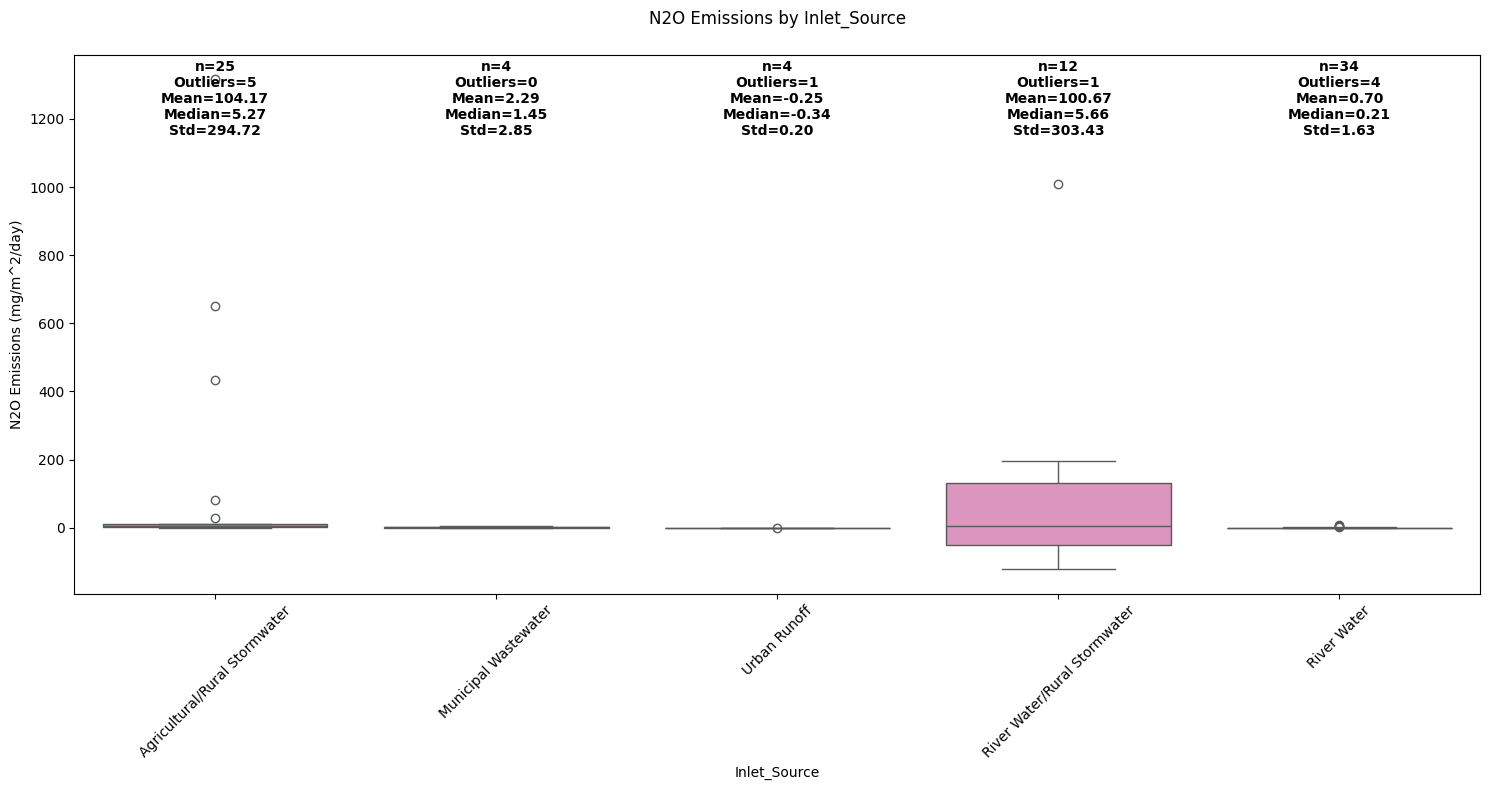

😔 Excluded from analysis due to small sample size: ['Municipal Wastewater', 'Urban Runoff']
Kruskal-Wallis H Test: Statistic=22.6748891620513, p-value=1.1918192055515163e-05


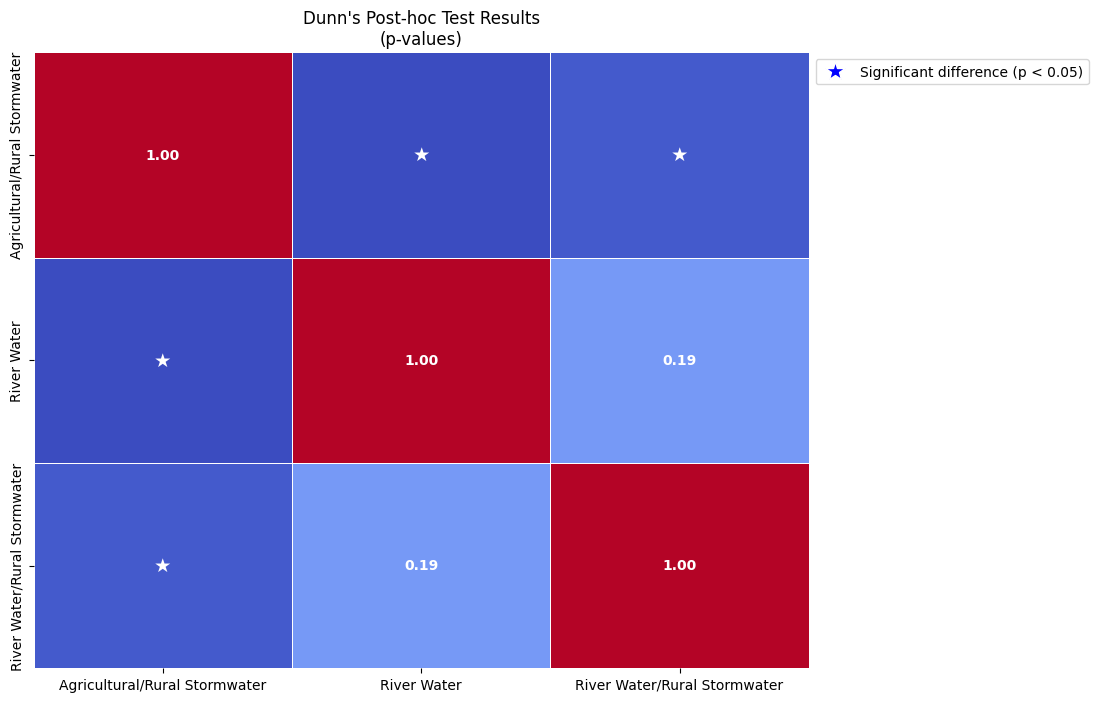

In [30]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Inlet_Source', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=10, y_limits=None)

In the case of **CH4**, Agricultural/Rural Stormwater presented the highest emissions, showing a statistical difference when compared with other inlets such as Urban Runoff, River Water/Rural Stormwater, River Water, and Agriculture. **A plausible reason for this could be the higher nutrient load and organic matter content in agricultural runoff, which can enhance microbial activity and methane production**. Agricultural activities often involve fertilizers and organic matter that can increase the availability of substrates for methanogens, leading to higher methane emissions.

Regarding **CO2** emissions, Urban Runoff exhibited the highest levels, followed by Agricultural/Rural Stormwater and River Water/Stormwater. **Urban Runoff might contribute to higher CO2 emissions due to the presence of organic pollutants, debris, and higher temperatures in urban areas that can enhance microbial respiration and CO2 production**. Urban areas tend to have more impervious surfaces, which increase runoff and can carry a variety of organic and inorganic pollutants that stimulate microbial activity and CO2 emissions.

In the case of **N2O**, the inlet sources from Agricultural/Rural Stormwater showed the largest emissions, with the lowest emissions observed in River Water. **This can be explained by the fact that agricultural runoff often contains high levels of nitrogen compounds from fertilizers, which can be converted to N2O through nitrification and denitrification processes**. Nitrous oxide is often produced in environments with high nitrate levels, which are common in agricultural runoff, leading to increased N2O emissions.

These findings underscore the significant influence of inlet source types on greenhouse gas emissions from constructed wetlands. **The nutrient and organic matter loads from different sources can significantly impact microbial processes, resulting in varying levels of GHG emissions**. Understanding these dynamics is crucial for designing and managing constructed wetlands to mitigate GHG emissions effectively.


## 2.7 Impact of the substrate

### CO2

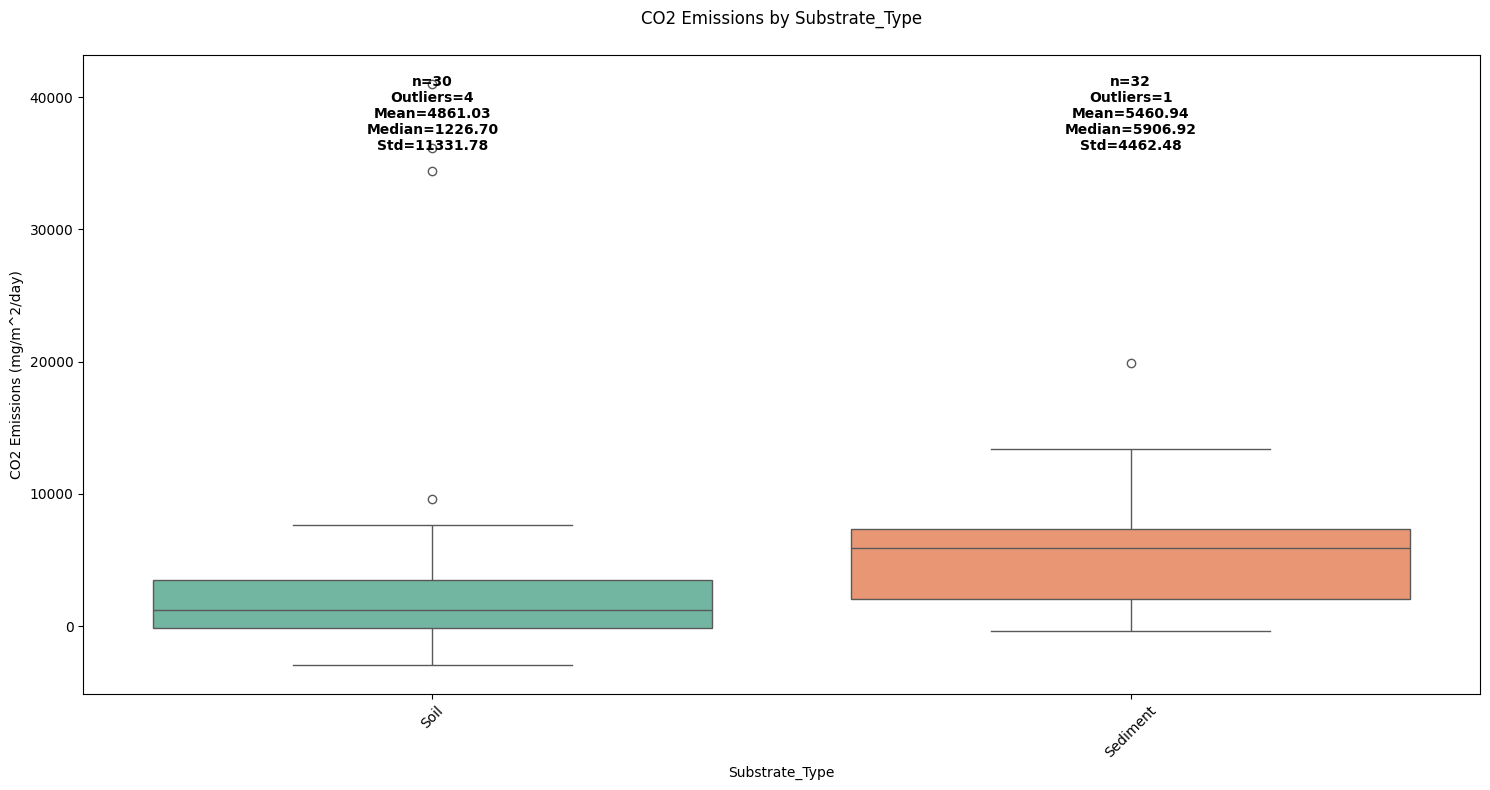

Kruskal-Wallis H Test: Statistic=7.857341269841271, p-value=0.005061476649336628


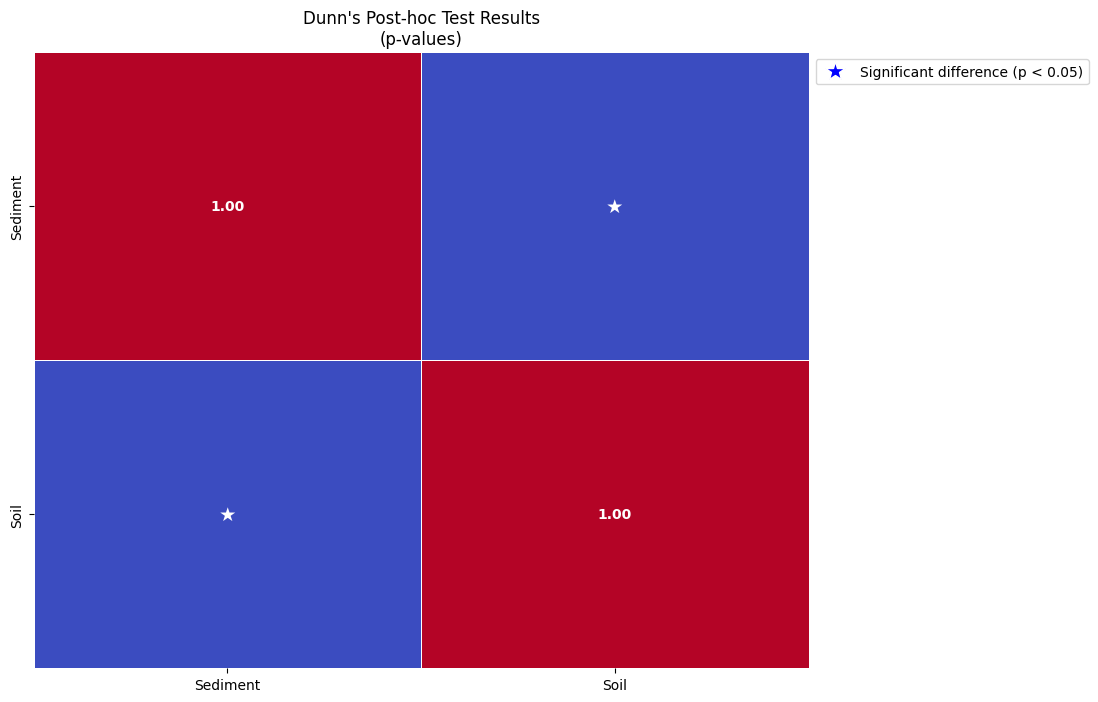

In [31]:
create_boxplot_and_stats(df = co2_chamber_data, value_column = 'Flux_Value', category_column = 'Substrate_Type', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=10, y_limits=None)

### CH4

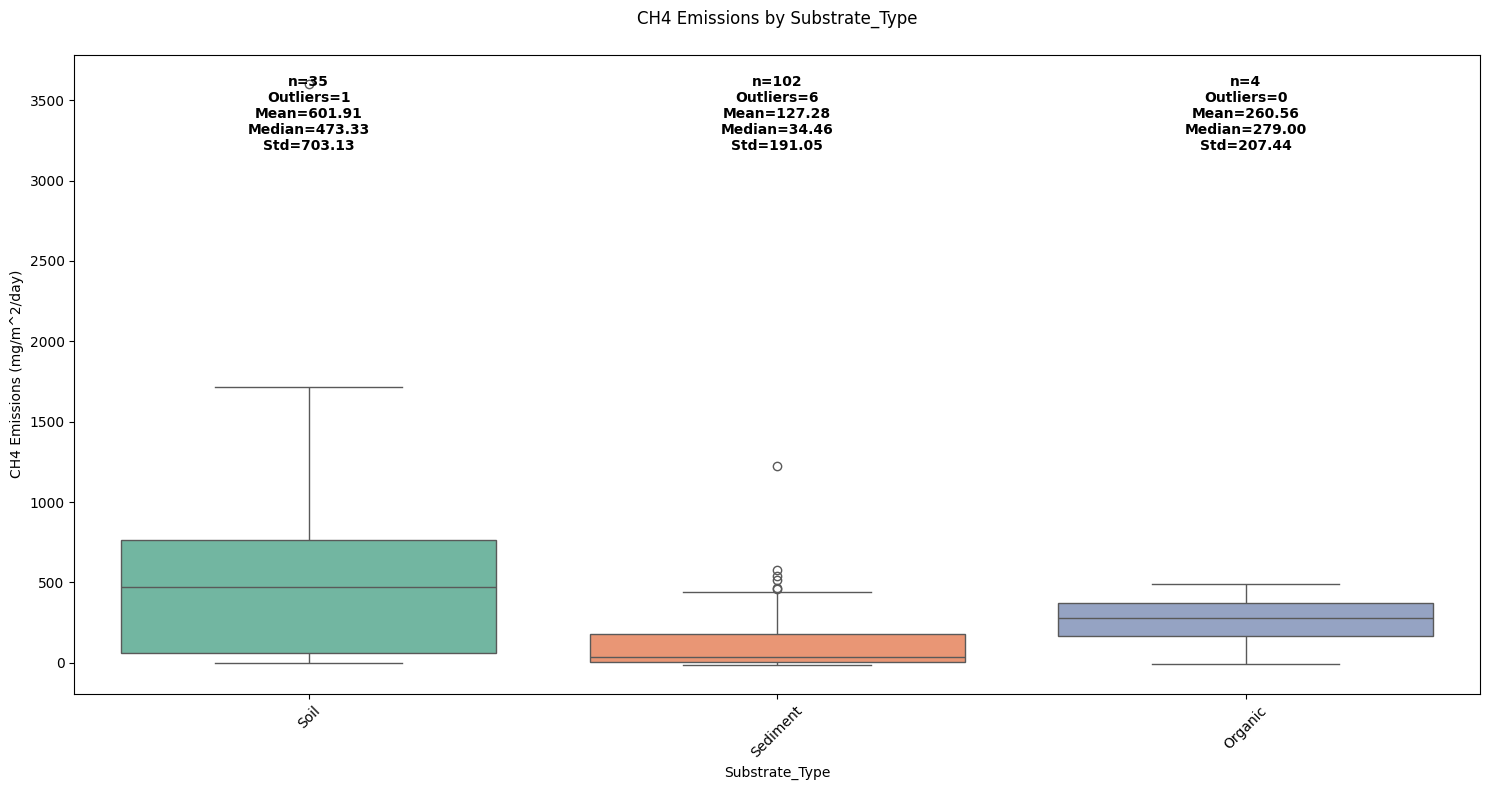

😔 Excluded from analysis due to small sample size: ['Organic']
Kruskal-Wallis H Test: Statistic=23.849357769313915, p-value=1.0417662966733065e-06


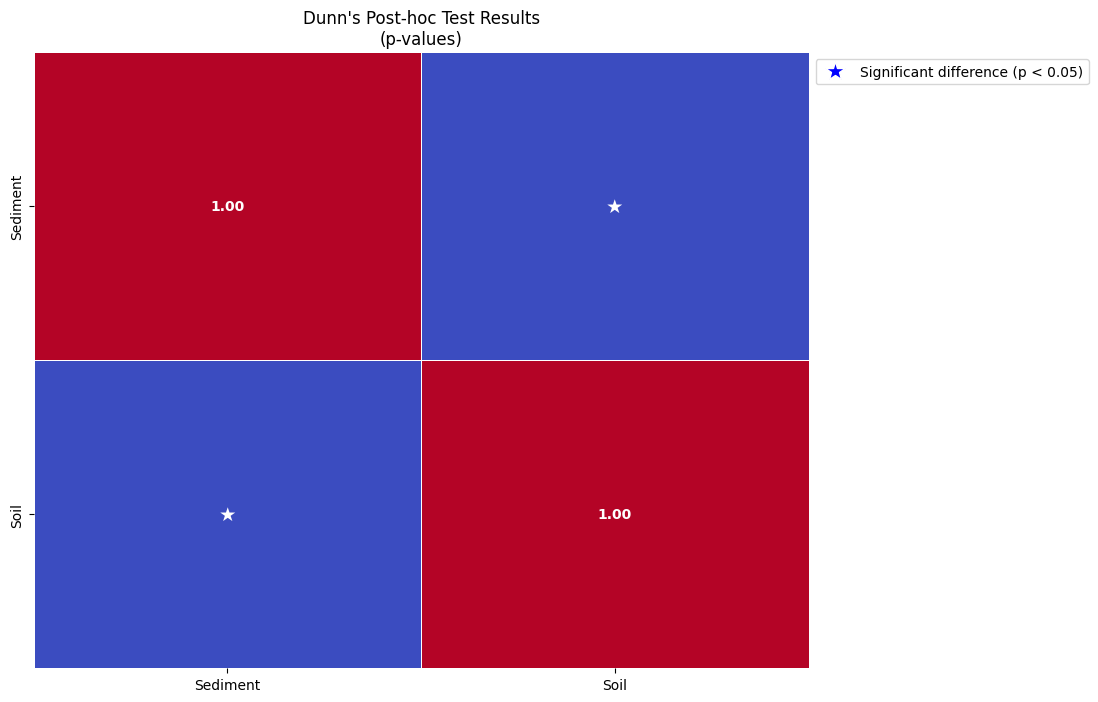

In [32]:
create_boxplot_and_stats(df = ch4_chamber_data, value_column = 'Flux_Value', category_column = 'Substrate_Type', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=10, y_limits=None)

### N2O

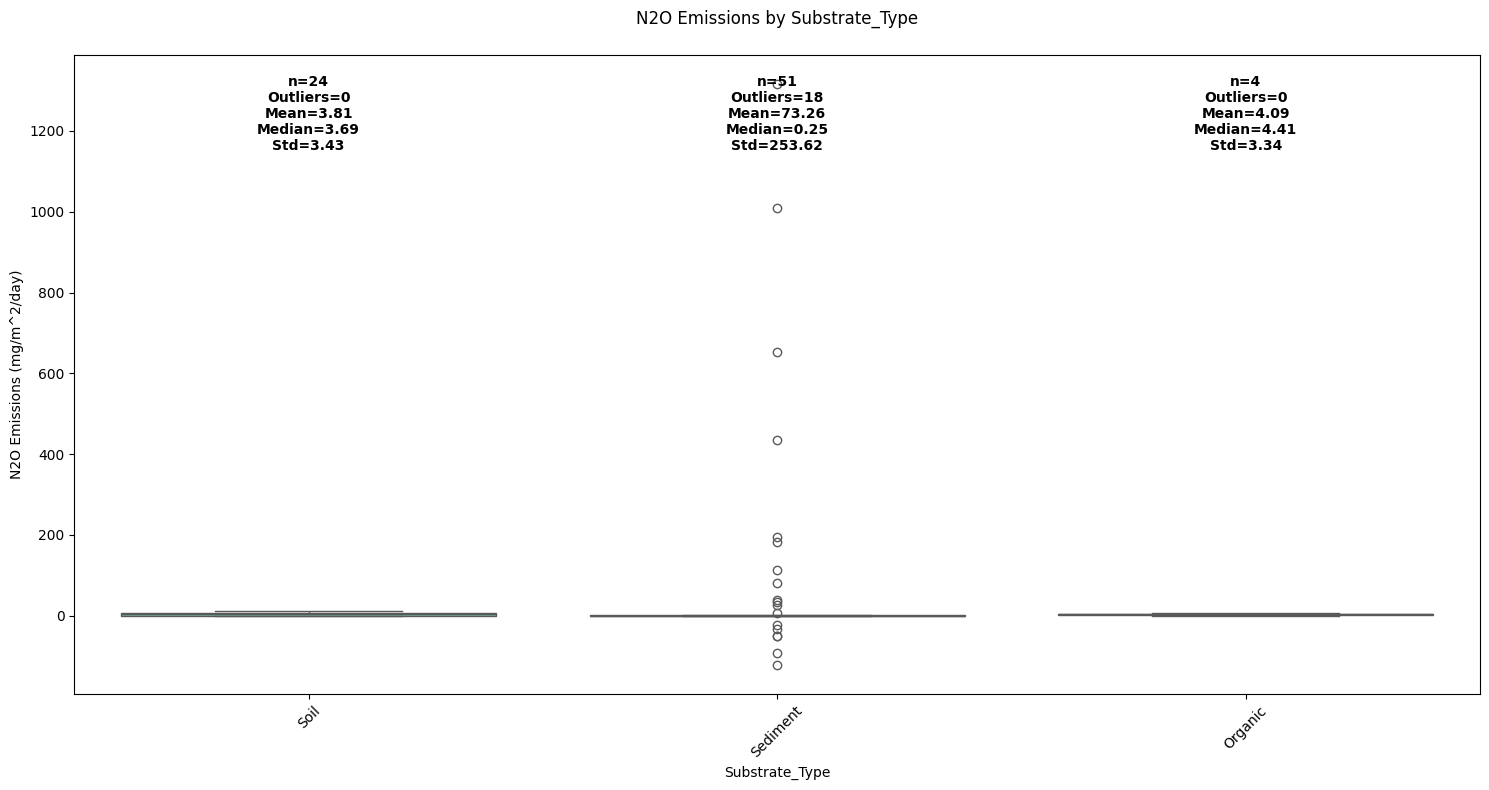

😔 Excluded from analysis due to small sample size: ['Organic']
Kruskal-Wallis H Test: Statistic=3.772863844264327, p-value=0.05209037417518892
No significant difference found by Kruskal-Wallis test.


In [33]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Substrate_Type', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=10, y_limits=None)

The analysis of substrate types reveals intriguing patterns in greenhouse gas emissions. **CO2 emissions** were lower in substrates containing soil compared to those with sediment. A plausible reason for this could be that soil has better carbon sequestration properties, reducing the amount of CO2 released. Soil might also support more diverse microbial communities that facilitate more efficient carbon cycling, thereby emitting less CO2.

However, for **CH4 emissions**, the opposite pattern was observed, with soil substrates showing higher emissions compared to sediment. This could be due to soil containing more organic matter that can decompose anaerobically to produce methane. Additionally, soil might support more extensive plant root systems that release exudates, providing substrates for methanogenic bacteria and increasing CH4 emissions.

For **N2O emissions**, there was no significant difference between substrate types. This might suggest that nitrous oxide production in constructed wetlands is influenced more by other factors, such as nitrogen availability and the presence of denitrifying bacteria, rather than the type of substrate.

These insights highlight the complex interactions between substrate type and greenhouse gas emissions in constructed wetlands. The findings suggest that managing substrate types could be a potential strategy to mitigate specific greenhouse gas emissions. For example, selecting substrates that minimize methane production while maintaining low CO2 emissions could be beneficial.


## 2.8 Impact of the operational period

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

def plot_scatter_with_regression(df, x_column, y_column, x_label, y_label, title):
    """
    Plot a scatter plot with a linear regression line and display the R² value.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    x_column (str): The name of the column containing the x values.
    y_column (str): The name of the column containing the y values.
    x_label (str): The label for the x-axis.
    y_label (str): The label for the y-axis.
    title (str): The title of the plot.
    """
    # Make a copy of the dataframe to avoid modifying the original data
    df_clean = df.copy()

    # Pre-cleaning: Remove rows where the y_column is NaN
    df_clean = df_clean.dropna(subset=[x_column])

    # Extract x and y values
    x = df_clean[x_column].values.reshape(-1, 1)
    y = df_clean[y_column].values.reshape(-1, 1)

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)

    # Create the scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_column, y=y_column, data=df_clean, color='blue', label='Data')
    plt.plot(df_clean[x_column], y_pred, color='red', linewidth=2, label=f'Linear Regression (R²={r2:.2f})')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage:
# plot_scatter_with_regression(df, 'Operational_Period_Years', 'GHG_Emissions', 'Operational Period (Years)', 'GHG Emissions', 'Operational Period vs GHG Emissions')


### CO2

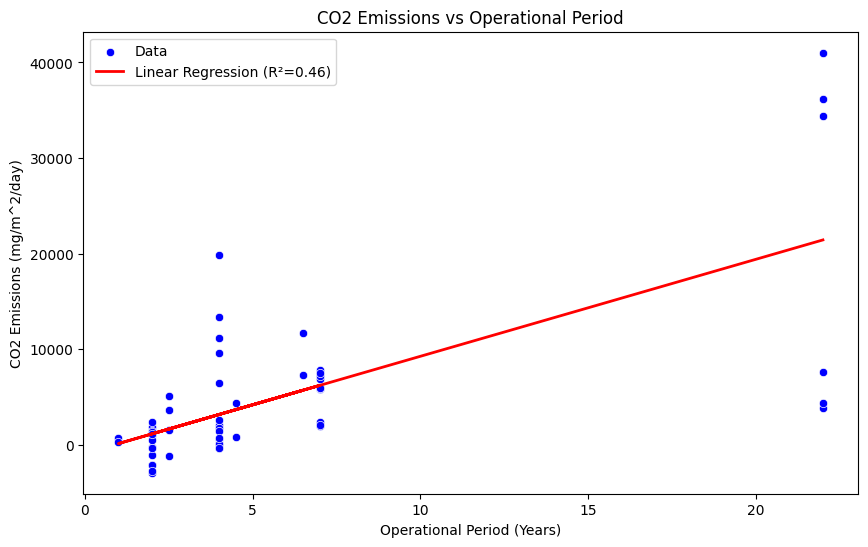

In [35]:
plot_scatter_with_regression(df = co2_chamber_data, x_column = 'Operational_Period_Years', y_column = 'Flux_Value', x_label = 'Operational Period (Years)', y_label = 'CO2 Emissions (mg/m^2/day)' , title = 'CO2 Emissions vs Operational Period')

### CH4

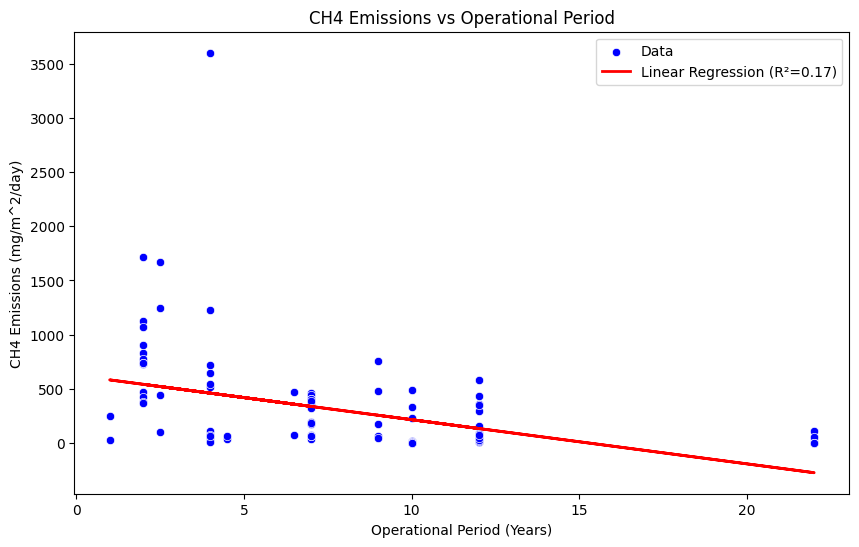

In [36]:
plot_scatter_with_regression(df = ch4_chamber_data, x_column = 'Operational_Period_Years', y_column = 'Flux_Value', x_label = 'Operational Period (Years)', y_label = 'CH4 Emissions (mg/m^2/day)' , title = 'CH4 Emissions vs Operational Period')

### N2O

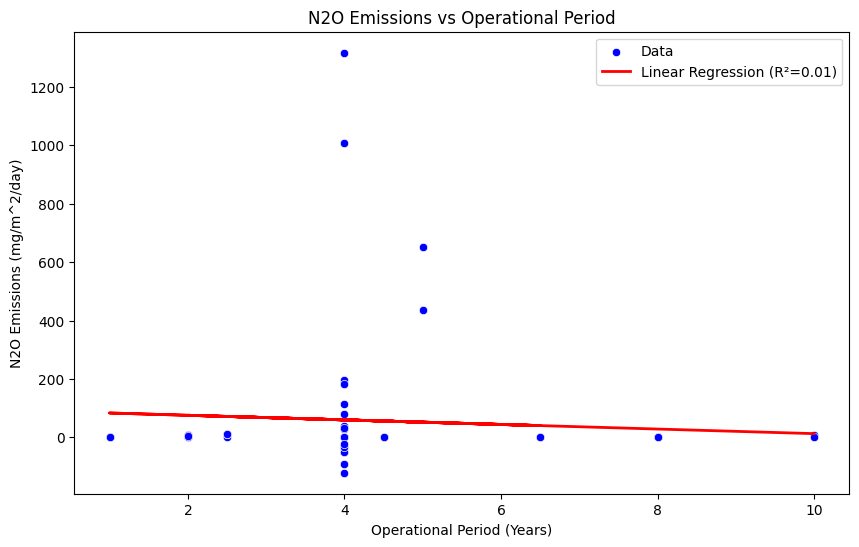

In [37]:
plot_scatter_with_regression(df = n2o_chamber_data, x_column = 'Operational_Period_Years', y_column = 'Flux_Value', x_label = 'Operational Period (Years)', y_label = 'N2O Emissions (mg/m^2/day)' , title = 'N2O Emissions vs Operational Period')

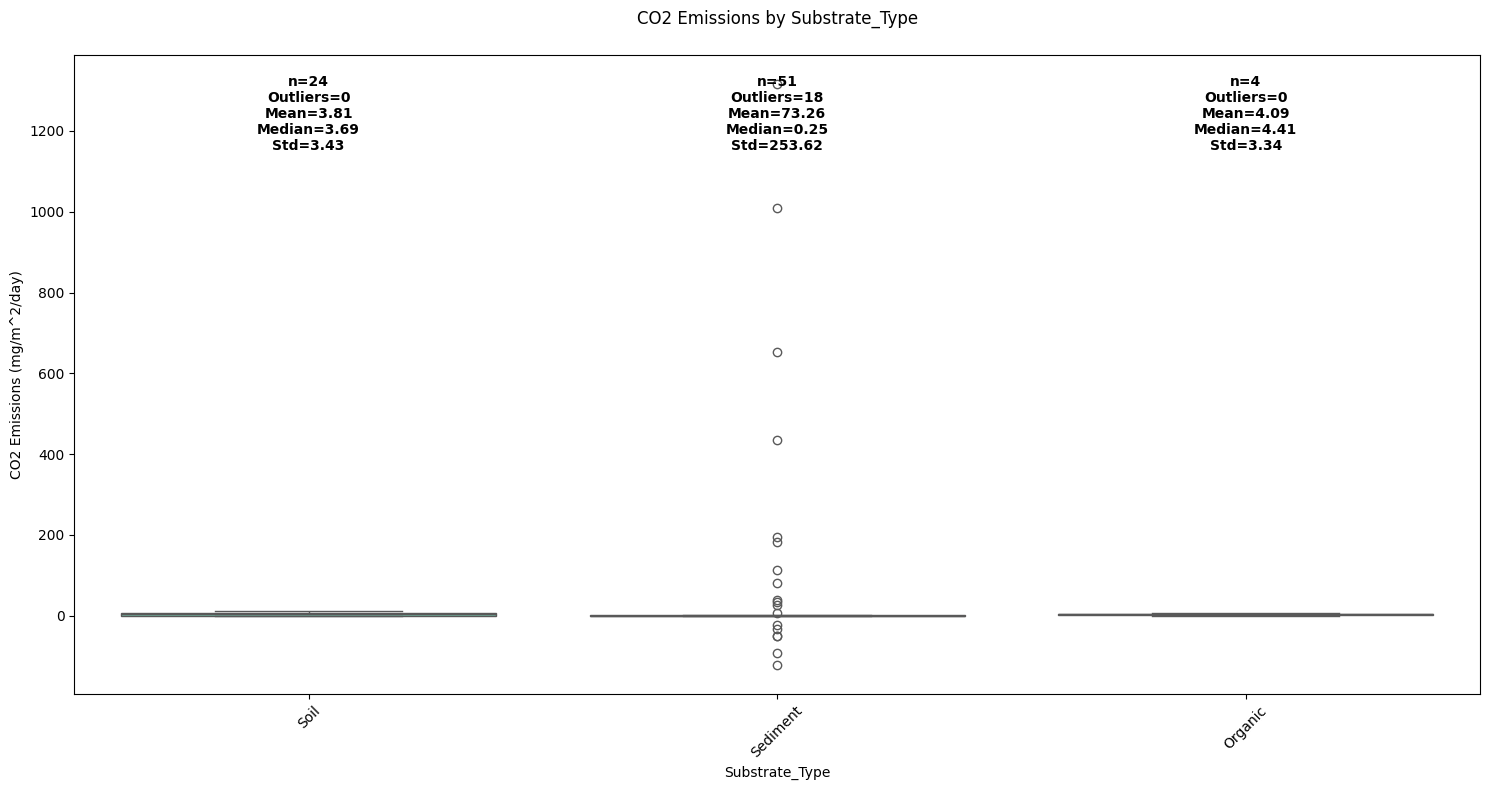

😔 Excluded from analysis due to small sample size: ['Organic']
Kruskal-Wallis H Test: Statistic=3.772863844264327, p-value=0.05209037417518892
No significant difference found by Kruskal-Wallis test.


In [38]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Substrate_Type', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=10, y_limits=None)

# 3. Analysis with environmental variables

In [131]:
import requests
import pandas as pd

def get_weather_data(latitude, longitude, start_date, end_date, parameters):
    base_url = "https://power.larc.nasa.gov/api/temporal/monthly/point"
    params = {
        "parameters": ",".join(parameters),
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "format": "json",
        "start": start_date,
        "end": end_date
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

# Example usage
latitude = 52.130333
longitude = 6.716592
start_date = "2012"
end_date = "2012"
#parameters = ["T2M", "PRECTOT", "RH2M"]  # Average temperature, total precipitation, relative humidity
parameters = list_indicators

weather_data = get_weather_data(latitude, longitude, start_date, end_date, parameters)

# Convert to DataFrame
weather_df = pd.json_normalize(weather_data['properties']['parameter'])
weather_df['latitude'] = latitude
weather_df['longitude'] = longitude
weather_df['year'] = start_date

weather_df


,TS_MAX.201201,TS_MAX.201202,TS_MAX.201203,TS_MAX.201204,TS_MAX.201205,TS_MAX.201206,TS_MAX.201207,TS_MAX.201208,TS_MAX.201209,TS_MAX.201210,...,CLRSKY_SFC_SW_DWN_MIN.201207,CLRSKY_SFC_SW_DWN_MIN.201208,CLRSKY_SFC_SW_DWN_MIN.201209,CLRSKY_SFC_SW_DWN_MIN.201210,CLRSKY_SFC_SW_DWN_MIN.201211,CLRSKY_SFC_SW_DWN_MIN.201212,CLRSKY_SFC_SW_DWN_MIN.201213,latitude,longitude,year
0,10.88,12.98,20.3,24.28,28.82,28.85,30.26,33.03,28.16,21.72,...,22.32,19.28,13.57,7.21,4.01,2.66,2.66,52.130333,6.716592,2012


In [103]:
indicators_score_df = pd.read_csv('/content/drive/MyDrive/🎓Uni/Data_analysis_wetlands/Resources/indicators_score_imp.csv')
indicators = [
    'Earth Skin Temperature Maximum',
    'Earth Skin Temperature Minimum',
    'Earth Skin Temperature Range',
    'Earth Skin Temperature Maximum Average',
    'Earth Skin Temperature Minimum Average',
    'Earth Skin Temperature Range Average',
    'Profile Soil Moisture',
    'Root Zone Soil Wetness',
    'Surface Soil Wetness',
    'Precipitation Corrected',
    'All Sky Surface Shortwave Downward Irradiance',
    'All Sky Surface Shortwave Downward Irradiance Maximum',
    'All Sky Surface Shortwave Downward Irradiance Minimum',
    'Clear Sky Surface Shortwave Downward Irradiance',
    'Clear Sky Surface Shortwave Downward Irradiance Maximum',
    'Clear Sky Surface Shortwave Downward Irradiance Minimum',
    'Midday Insolation Incident',
    'Surface Albedo Adjusted',
    'Clear Sky Surface Albedo',
    'Cloud Amount'
]

In [ ]:
filtered_indicators = indicators_score_df[indicators_score_df['name'].isin(indicators)].reset_index(drop=True).drop(columns=['index', 'Unnamed: 11'])
filtered_indicators

In [116]:
list_indicators = list(filtered_indicators['variable_name'].values)

In [117]:
weather_data = get_weather_data(latitude, longitude, start_date, end_date, list_indicators)

In [129]:
df_data = df[['Latitude', 'Longitude', 'Year']].drop_duplicates().dropna(subset=['Latitude', 'Longitude']).reset_index(drop=True)
df_data

,Latitude,Longitude,Year
0,52.130333,6.716592,2012
1,38.975140,100.446400,2012
2,38.975140,100.446400,2013
3,38.975140,100.446400,2014
4,40.000000,-83.016667,2002
5,40.000000,-83.016667,2003
6,41.816667,-72.250000,2014
7,60.416700,24.366700,2002
8,64.906111,25.471111,2002
9,48.538600,3.063100,2014


In [137]:
row_index = 0
latitude = df_data.loc[row_index, 'Latitude']
longitude = df_data.loc[row_index, 'Longitude']
start_date = df_data.loc[row_index, 'Year']
end_date = df_data.loc[row_index, 'Year']
parameters = list_indicators
weather_data = get_weather_data(latitude, longitude, start_date, end_date, parameters)

# Convert to DataFrame
weather_df = pd.json_normalize(weather_data['properties']['parameter'])
weather_df['latitude'] = latitude
weather_df['longitude'] = longitude
weather_df['year'] = start_date

weather_df

,TS_MAX.201201,TS_MAX.201202,TS_MAX.201203,TS_MAX.201204,TS_MAX.201205,TS_MAX.201206,TS_MAX.201207,TS_MAX.201208,TS_MAX.201209,TS_MAX.201210,...,CLRSKY_SFC_SW_DWN_MIN.201207,CLRSKY_SFC_SW_DWN_MIN.201208,CLRSKY_SFC_SW_DWN_MIN.201209,CLRSKY_SFC_SW_DWN_MIN.201210,CLRSKY_SFC_SW_DWN_MIN.201211,CLRSKY_SFC_SW_DWN_MIN.201212,CLRSKY_SFC_SW_DWN_MIN.201213,latitude,longitude,year
0,10.88,12.98,20.3,24.28,28.82,28.85,30.26,33.03,28.16,21.72,...,22.32,19.28,13.57,7.21,4.01,2.66,2.66,52.130333,6.716592,2012


In [139]:
weather_df.to_csv('weather_data.csv', index=False)

In [140]:
!pwd

/content


In [144]:
for i in range(30):
  row_index = 0
  latitude = df_data.loc[row_index, 'Latitude']
  longitude = df_data.loc[row_index, 'Longitude']
  start_date = df_data.loc[row_index, 'Year']
  end_date = df_data.loc[row_index, 'Year']
  parameters = list_indicators
  weather_data = get_weather_data(latitude, longitude, start_date, end_date, parameters)

  # Convert to DataFrame
  weather_df = pd.json_normalize(weather_data['properties']['parameter'])
  weather_df['latitude'] = latitude
  weather_df['longitude'] = longitude
  weather_df['year'] = start_date

  weather_df.to_csv(f'weather_data_{i}.csv', index=False)
  print(f'Index {i} DONE')

Index 0 DONE
Index 1 DONE
Index 2 DONE
Index 3 DONE
Index 4 DONE
Index 5 DONE
Index 6 DONE
Index 7 DONE
Index 8 DONE
Index 9 DONE
Index 10 DONE
Index 11 DONE
Index 12 DONE
Index 13 DONE
Index 14 DONE
Index 15 DONE
Index 16 DONE
Index 17 DONE
Index 18 DONE
Index 19 DONE
Index 20 DONE
Index 21 DONE
Index 22 DONE
Index 23 DONE
Index 24 DONE
Index 25 DONE
Index 26 DONE


KeyboardInterrupt: 